<a href="https://colab.research.google.com/github/JMauroSH/Prediccion_Ventas/blob/main/Predicciones_con_3_modelos_con_todos_los_datos_y_desde_2021_productoTOP_1_PrimeraSucursal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
from pandas import set_option, read_csv, to_datetime, merge, date_range, Series, Timedelta, DataFrame
from numpy import abs, array, mean, sqrt
from matplotlib.pyplot import plot, xlim, ylim, title, show, xlabel, ylabel, legend, figure, style, rcParams, subplots, tight_layout, xticks
from seaborn import set_palette
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
# file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_11_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
file_name = "tabla_11_modif_top10ventas_nov_v2.csv"
df = read_csv(file_name)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,11,1,AC,SVE,VENTA COMPUTARIZADA,18110999,0,2018-11-06,POLLO SIN MENUDENCIA H-C,KG,0.0000,1.2415,15.1300,10.8580,10.8580,2.1743,FAENEADO
1,11,1,AC,SVE,VENTA COMPUTARIZADA,18110996,0,2018-11-06,CORAZON,KG,0.0000,0.9274,11.5700,11.1250,11.1250,1.6625,FAENEADO
2,11,1,AC,SVE,VENTA COMPUTARIZADA,18110995,0,2018-11-06,POLLO SIN MENUDENCIA H-C,KG,0.0000,23.6785,288.8940,10.8580,10.8580,41.5078,FAENEADO
3,11,1,AC,SVE,VENTA COMPUTARIZADA,18110992,0,2018-11-06,CORAZON,KG,0.0000,0.8927,11.1250,11.1250,11.1250,1.5984,FAENEADO
4,11,1,AC,SVE,VENTA COMPUTARIZADA,18110978,0,2018-11-06,CORAZON,KG,0.0000,2.6700,33.3750,11.1250,11.1250,4.7953,FAENEADO


In [ ]:
df['FechaMovimiento'] = to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [ ]:
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-2e7c75eefad5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


### seleccion del top 1

In [ ]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar el nombre del primer producto
nombre_primer_producto = top_10_productos.index[0]

# Crear un DataFrame para el primer producto y sumar las ventas por dia
df_top_1 = df_todo[df_todo['NombreProducto'] == nombre_primer_producto].groupby(['FechaMovimiento', 'NombreProducto']).sum().reset_index()

print("\nDataFrame df_top_1:")
print(df_top_1)

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'CORAZON', 'PECHUGA',
       'CUELLO', 'RABADILLA', 'HIGADO', 'MENUDENCIA',
       'SACHET MORTADELA DE POLLO 200 GRS', 'PATE GRANDE 200G'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
                      NombreProducto  DiasDeVenta
0           POLLO SIN MENUDENCIA H-C         1711
1                             CUELLO         1577
2                             HIGADO         1458
3                            CORAZON         1360
4                         MENUDENCIA         1346
5                       PIERNA MUSLO         1346
6                            PECHUGA         1312
7                          RABADILLA         1307
8                   PATE GRANDE 200G          918
9  SACHET MORTADELA DE POLLO 200 GRS          886

DataFrame df_top_1:
     FechaMovimiento            NombreProducto  MontoBase    year
0         2018-11-03  POLLO SIN MENUDENCIA H-C  7

In [ ]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_top_1[(df_top_1['FechaMovimiento'] >= '2023-11-01') & (df_top_1['FechaMovimiento'] <= '2023-11-30')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_top_1[df_top_1['FechaMovimiento'] < '2023-11-01']

df_top_1 = df_top_1[df_top_1['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (279990, 4)
sin noviembre  (1677, 4)
noviembre 2023  (30, 4)


### verificar las fechas faltantes y rellenarlas

In [ ]:
# from sklearn.impute import KNNImputer
from copy import deepcopy

In [ ]:
# #df_noviembre.head()
# print(df_todo_hasta_nov)
# print(df_todo_hasta_nov.dtypes)

In [ ]:
df_todas_fechas_hasta_nov = deepcopy(df_todo_hasta_nov)

# Convertir la columna 'FechaMovimiento' a tipo datetime si aún no lo está
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# Establecer 'FechaMovimiento' como el índice
df_todas_fechas_hasta_nov.set_index('FechaMovimiento', inplace=True)

# Reindexar para incluir todas las fechas desde el inicio hasta el final del rango deseado
inicio = df_todas_fechas_hasta_nov.index.min()
fin = df_todas_fechas_hasta_nov.index.max()
fechas_completas = date_range(start=inicio, end=fin)

# Contar cuántas fechas faltantes se agregaron
fechas_faltantes = fechas_completas.difference(df_todas_fechas_hasta_nov.index)
contador_fechas_faltantes = len(fechas_faltantes)

# Reindexar el DataFrame para incluir todas las fechas
df_todas_fechas_hasta_nov = df_todas_fechas_hasta_nov.reindex(fechas_completas)

# # Rellenar los valores faltantes utilizando KNNImputer
# imputer = KNNImputer(n_neighbors=5)  # Puedes ajustar el número de vecinos según tu preferencia
# df_todas_fechas_hasta_nov['MontoBase'] = imputer.fit_transform(df_todas_fechas_hasta_nov[['MontoBase']])
# Rellenar los valores faltantes utilizando el método ffill() (forward fill)
df_todas_fechas_hasta_nov['MontoBase'] = df_todas_fechas_hasta_nov['MontoBase'].ffill()
# Rellenar los valores faltantes con ceros
# df_todas_fechas_hasta_nov['MontoBase'].fillna(0, inplace=True)

# Imprimir el DataFrame resultante
print("Número de fechas faltantes agregadas:", contador_fechas_faltantes)
# print(df_todas_fechas_hasta_nov)

# Reiniciar el índice y mantener el nombre de la columna de fecha
df_todas_fechas_hasta_nov.reset_index(inplace=True, drop=False)
df_todas_fechas_hasta_nov.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

# Imprimir el DataFrame resultante
print(df_todas_fechas_hasta_nov)

Número de fechas faltantes agregadas: 147
     FechaMovimiento            NombreProducto  MontoBase        year
0         2018-11-03  POLLO SIN MENUDENCIA H-C  7795.8660 308754.0000
1         2018-11-04  POLLO SIN MENUDENCIA H-C  5278.5900 226016.0000
2         2018-11-05  POLLO SIN MENUDENCIA H-C  5096.8520 264358.0000
3         2018-11-06  POLLO SIN MENUDENCIA H-C  3420.9820 121080.0000
4         2018-11-07  POLLO SIN MENUDENCIA H-C  3968.6880 201800.0000
...              ...                       ...        ...         ...
1819      2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036 196231.0000
1820      2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542 192185.0000
1821      2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544  10115.0000
1822      2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227 333795.0000
1823      2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832 202300.0000

[1824 rows x 4 columns]


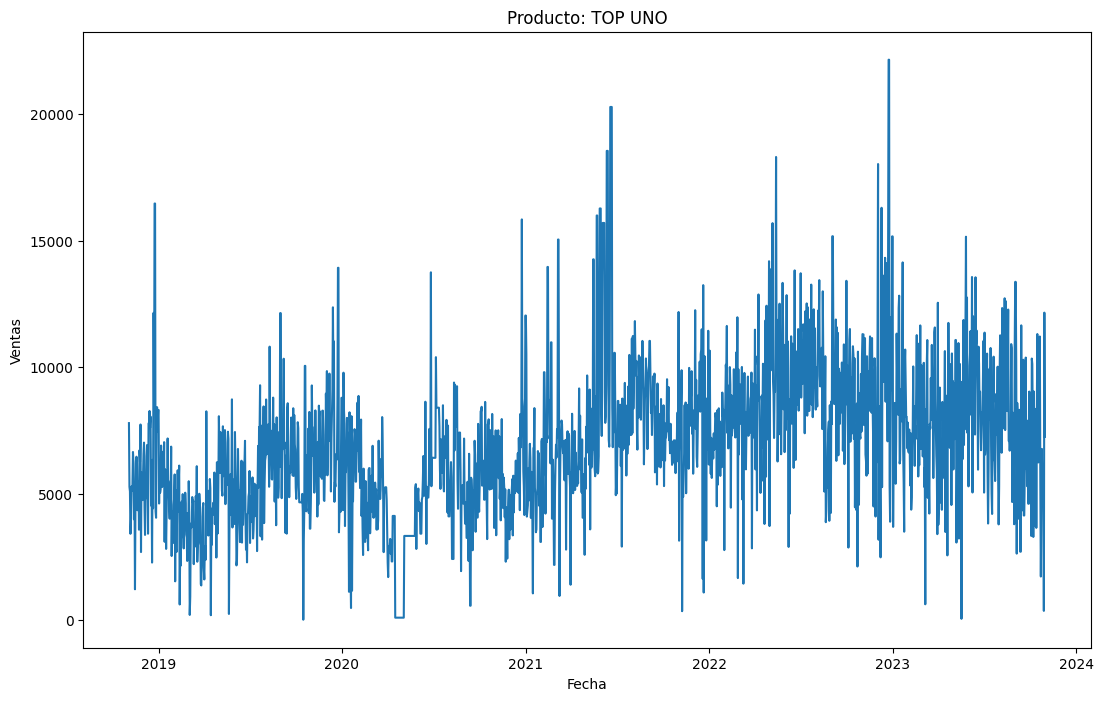

In [ ]:
figure(figsize=(13, 8))
# Crear un gráfico de líneas para cada producto
plot(df_todas_fechas_hasta_nov['FechaMovimiento'], df_todas_fechas_hasta_nov['MontoBase'], label=df_todas_fechas_hasta_nov['NombreProducto'])
title(f'Producto: TOP UNO')
xlabel('Fecha')
ylabel('Ventas')
show()

In [ ]:
# df_noviembre.tail()

## Metricas de Evaluación

In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = array(y_true), array(y_pred)
        return mean(abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'NombreProducto',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

# df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  3239.2974
1      2023-11-02  7098.1327
2      2023-11-03  4978.8291
3      2023-11-04  4431.8618
4      2023-11-05  4541.8035
5      2023-11-06  7492.0734
6      2023-11-07  7305.7163
7      2023-11-08  4343.5560
8      2023-11-09  3487.1891
9      2023-11-10  1528.0410
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


# PROPHET


### Preparado de los DataFrame

In [ ]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = to_datetime(df_todo_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todas_fechas_hasta_nov['FechaMovimiento'] = df_todas_fechas_hasta_nov['FechaMovimiento'].dt.date

# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todas_fechas_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of      FechaMovimiento            NombreProducto  MontoBase    year
1677      2023-11-01  POLLO SIN MENUDENCIA H-C  3239.2974   93058
1678      2023-11-02  POLLO SIN MENUDENCIA H-C  7098.1327  105196
1679      2023-11-03  POLLO SIN MENUDENCIA H-C  4978.8291  167909
1680      2023-11-04  POLLO SIN MENUDENCIA H-C  4431.8618  127449
1681      2023-11-05  POLLO SIN MENUDENCIA H-C  4541.8035  135541
1682      2023-11-06  POLLO SIN MENUDENCIA H-C  7492.0734  315588
1683      2023-11-07  POLLO SIN MENUDENCIA H-C  7305.7163  230622
1684      2023-11-08  POLLO SIN MENUDENCIA H-C  4343.5560  167909
1685      2023-11-09  POLLO SIN MENUDENCIA H-C  3487.1891   97104
1686      2023-11-10  POLLO SIN MENUDENCIA H-C  1528.0410   22253
1687      2023-11-11  POLLO SIN MENUDENCIA H-C  7330.7520  252875
1688      2023-11-12  POLLO SIN MENUDENCIA H-C  4889.5888  121380
1689      2023-11-13  POLLO SIN MENUDENCIA H-C  7760.8445  269059
1690      2023-11-14  POLLO SIN MENUDENCIA H-C

In [ ]:
df_todo_hasta_nov['FechaMovimiento'] = to_datetime(df_todo_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# df_todo_hasta_nov_desde_2021 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year < 2021)]
df_todo_hasta_nov_desde_2021 = df_todas_fechas_hasta_nov[~(df_todas_fechas_hasta_nov['FechaMovimiento'].dt.year < 2021)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)

# se devuelve el tipo object a FechaMovimiento para Prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)
print(df_todo_hasta_nov_desde_2021.shape)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
    FechaMovimiento            NombreProducto  MontoBase        year
790      2021-01-01                       NaN 12048.0190         NaN
791      2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000 353675.0000
792      2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080  97008.0000
793      2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650 147533.0000
794      2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320 194016.0000
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                      float64
dtype: object
------------------------------
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimi

<ipython-input-57-7783d2d7eb46>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date


In [ ]:
# Sumamos las ventas por dia y cambiamos de nombre las columnas para el modelo Prophet
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_desde_2021_prophet.head)
print(df_todo_hasta_nov_desde_2021_prophet.shape)

<bound method NDFrame.head of               ds          y
0     2021-01-01 12048.0190
1     2021-01-02 10510.9000
2     2021-01-03  4100.4080
3     2021-01-04  4341.8650
4     2021-01-05  4555.7320
...          ...        ...
1029  2023-10-27  6026.4036
1030  2023-10-28  5949.4542
1031  2023-10-29   374.6544
1032  2023-10-30 12163.1227
1033  2023-10-31  7254.2832

[1034 rows x 2 columns]>
(1034, 2)


## Predicciones con todos los datos y desde 2021 del producto top 1

este producto esta en el dataframe df_top_1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4cq585p/8ugqj_ko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4cq585p/xduldpv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running 

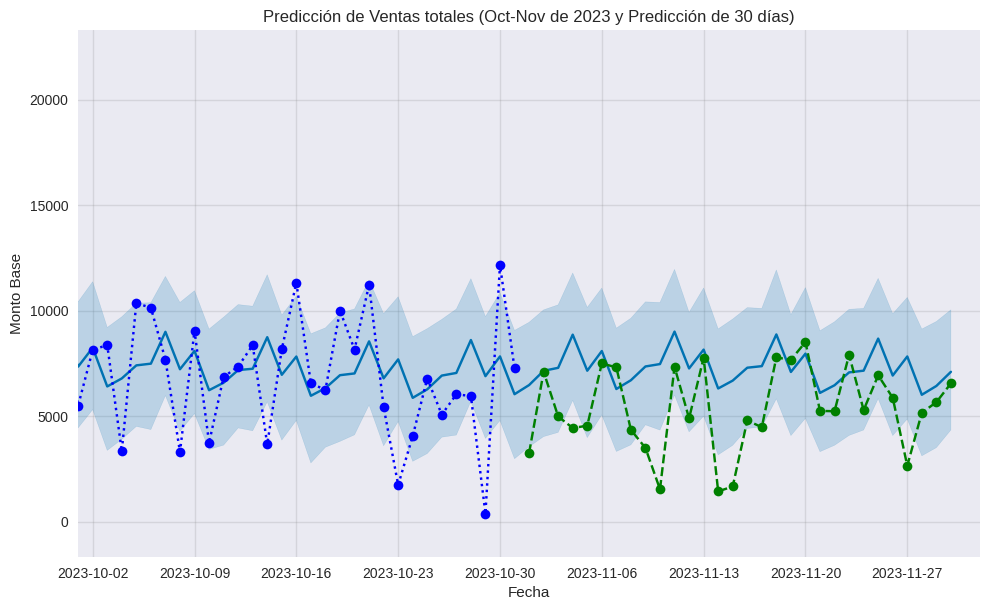

<Figure size 1600x1000 with 0 Axes>

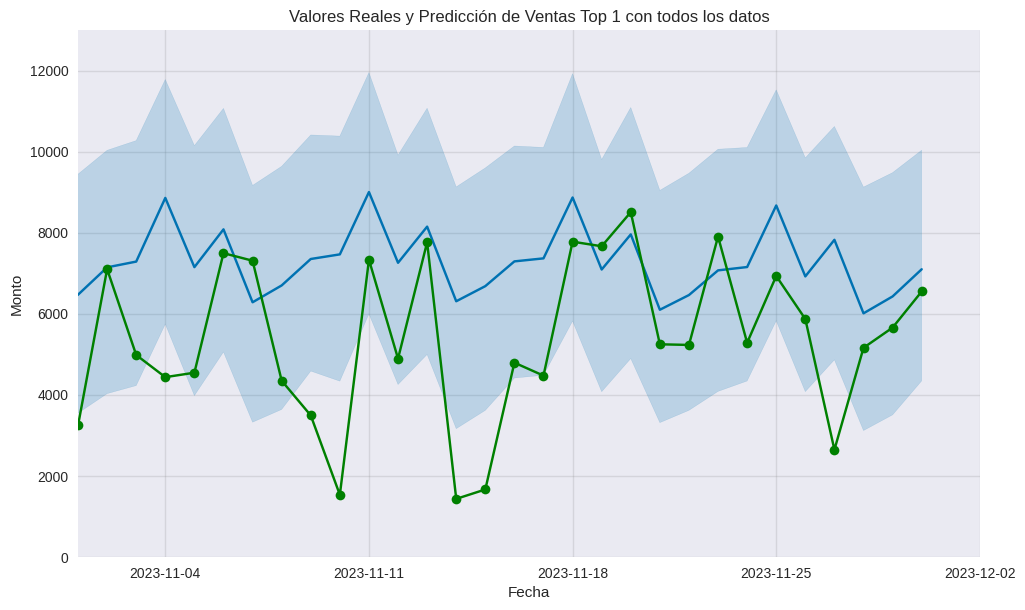

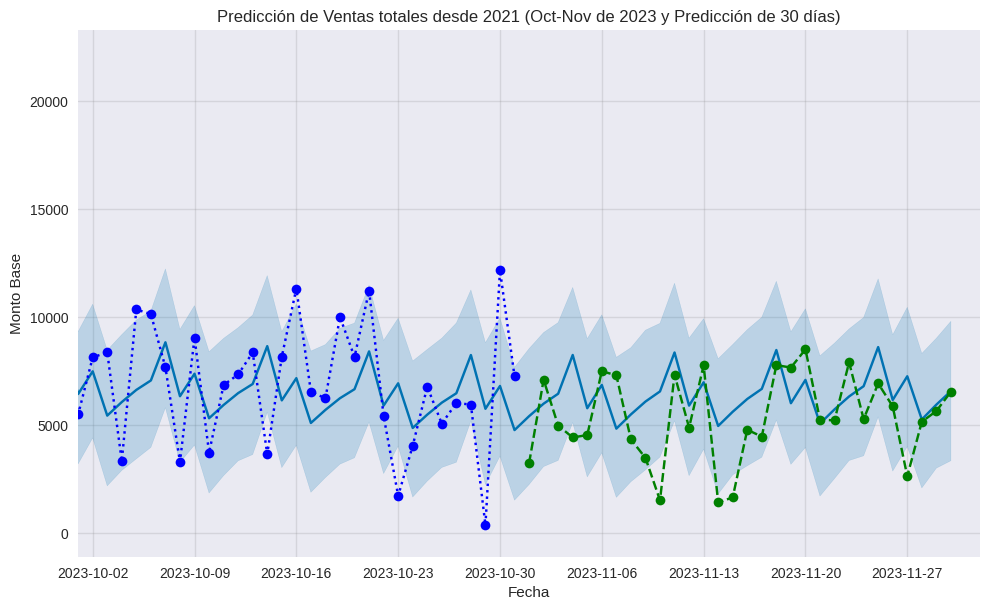

<Figure size 1600x1000 with 0 Axes>

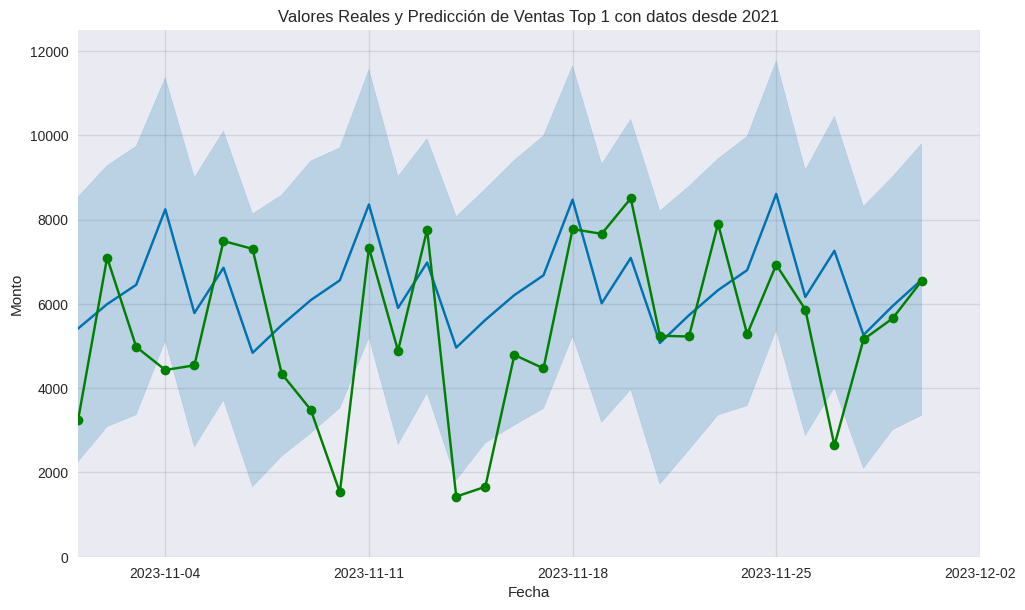

prediccion con todos los valores :              ds      yhat
1824 2023-11-01 6466.6419
1825 2023-11-02 7141.8419
1826 2023-11-03 7284.2322
1827 2023-11-04 8855.8544
1828 2023-11-05 7147.1436
1829 2023-11-06 8079.6523
1830 2023-11-07 6279.8858
1831 2023-11-08 6695.8417
1832 2023-11-09 7348.3691
1833 2023-11-10 7462.3725
1834 2023-11-11 9000.6650
1835 2023-11-12 7254.6123
1836 2023-11-13 8146.8360
1837 2023-11-14 6305.0237
1838 2023-11-15 6678.4401
1839 2023-11-16 7289.2547
1840 2023-11-17 7363.7120
1841 2023-11-18 8865.9502
1842 2023-11-19 7088.6102
1843 2023-11-20 7955.5032
1844 2023-11-21 6095.3891
1845 2023-11-22 6458.4557
1846 2023-11-23 7067.6190
1847 2023-11-24 7149.6695
1848 2023-11-25 8669.0715
1849 2023-11-26 6918.5582
1850 2023-11-27 7821.7908
1851 2023-11-28 6007.1338
1852 2023-11-29 6424.1376
1853 2023-11-30 7094.8486
prediccion desde el 2021 :              ds      yhat
1034 2023-11-01 5414.5022
1035 2023-11-02 5993.6987
1036 2023-11-03 6453.2464
1037 2023-11-04 8244.6862
10

In [ ]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-10-01'
fecha_fin_str = '2023-12-02'
fecha_inicio_nov_str = '2023-11-01'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')
fecha_inicio_nov = datetime.strptime(fecha_inicio_nov_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_desde_2021_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar las predicciones con límites ajustados
fig = modelo1.plot(prediccion1)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o', linestyle='dashed')
plot(df_todo_hasta_nov_prophet['ds'], df_todo_hasta_nov_prophet['y'], label='Ventas reales de noviembre', color='blue', marker='o', linestyle='dotted')
# Aplicar límites al eje x
xlim([fecha_inicio, fecha_fin])
xlabel('Fecha')
ylabel('Monto Base')
title(f'Predicción de Ventas totales (Oct-Nov de 2023 y Predicción de 30 días)')
show()

figure(figsize=(16, 10))
fig = modelo1.plot(prediccion1)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas Reales Noviembre', color='green', marker='o')
title(f'Valores Reales y Predicción de Ventas Top 1 con todos los datos')
xlim([fecha_inicio_nov, fecha_fin])
ylim([0,13000])
xlabel('Fecha')
ylabel('Monto')
show()

fig = modelo2.plot(prediccion2)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o', linestyle='dashed')
plot(df_todo_hasta_nov_prophet['ds'], df_todo_hasta_nov_prophet['y'], label='Ventas reales de noviembre', color='blue', marker='o', linestyle='dotted')
xlim([fecha_inicio, fecha_fin])
title(f'Predicción de Ventas totales desde 2021 (Oct-Nov de 2023 y Predicción de 30 días)')
xlabel('Fecha')
ylabel('Monto Base')
show()

figure(figsize=(16, 10))
fig = modelo2.plot(prediccion2)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o')
title(f'Valores Reales y Predicción de Ventas Top 1 con datos desde 2021')
xlim([fecha_inicio_nov, fecha_fin])
ylim([0,12500])
xlabel('Fecha')
ylabel('Monto')
show()

# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores :" , valores_prediccion1)
print("prediccion desde el 2021 :" , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# show()

# fig = modelo2.plot(prediccion2)
# show()

## EVALUACION

evaluacion con todos los datos


In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  3239.2974
1      2023-11-02  7098.1327
2      2023-11-03  4978.8291
3      2023-11-04  4431.8618
4      2023-11-05  4541.8035
5      2023-11-06  7492.0734
6      2023-11-07  7305.7163
7      2023-11-08  4343.5560
8      2023-11-09  3487.1891
9      2023-11-10  1528.0410
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print(valores_prediccion1.describe)
# print(df_noviembre_sumaT.shape)
# df_noviembre_sumaT.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  3239.2974       6466.6419
1       2023-11-02  7098.1327       7141.8419
2       2023-11-03  4978.8291       7284.2322
3       2023-11-04  4431.8618       8855.8544
4       2023-11-05  4541.8035       7147.1436
5       2023-11-06  7492.0734       8079.6523
6       2023-11-07  7305.7163       6279.8858
7       2023-11-08  4343.5560       6695.8417
8       2023-11-09  3487.1891       7348.3691
9       2023-11-10  1528.0410       7462.3725
10      2023-11-11  7330.7520       9000.6650
11      2023-11-12  4889.5888       7254.6123
12      2023-11-13  7760.8445       8146.8360
13      2023-11-14  1427.7825       6305.0237
14      2023-11-15  1659.6720       6678.4401
15      2023-11-16  4789.3392       7289.2547
16      2023-11-17  4469.1706       7363.7120
17      2023-11-18  7775.5295       8865.9502
18      2023-11-19  7662.2770       7088.6102
19      2023-11-20  8504.3950       7955.5032
20      2023-11-21  5242.8209     

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 7071201.030356657
MAE is : 2107.3865450620237
R2 is : -0.8278550755786516 %
------------------------------
RMSE is : 2659.172997448014
MAPE is : 70.24891224289186 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evaluación desde 2021

In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_desde_2021['FechaMovimiento'] = to_datetime(df_noviembre_desde_2021['FechaMovimiento'])
valores_prediccion2['ds'] = to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_desde_2021 = merge(df_noviembre_desde_2021, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_desde_2021.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_desde_2021.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  3239.2974       5414.5022
1       2023-11-02  7098.1327       5993.6987
2       2023-11-03  4978.8291       6453.2464
3       2023-11-04  4431.8618       8244.6862
4       2023-11-05  4541.8035       5783.0956
5       2023-11-06  7492.0734       6858.3319
6       2023-11-07  7305.7163       4838.8851
7       2023-11-08  4343.5560       5496.7389
8       2023-11-09  3487.1891       6089.6424
9       2023-11-10  1528.0410       6560.0966
10      2023-11-11  7330.7520       8359.6463
11      2023-11-12  4889.5888       5903.4763
12      2023-11-13  7760.8445       6981.6532
13      2023-11-14  1427.7825       4962.9729
14      2023-11-15  1659.6720       5619.8129
15      2023-11-16  4789.3392       6210.3927
16      2023-11-17  4469.1706       6677.7458
17      2023-11-18  7775.5295       8473.9952
18      2023-11-19  7662.2770       6014.9312
19      2023-11-20  8504.3950       7091.2329


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 4550463.356812497
MAE is : 1673.291054507667
R2 is : -0.17626235023965497 %
------------------------------
RMSE is : 2133.1815105172127
MAPE is : 54.30737132828287 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LSTM


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler

In [ ]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

  FechaMovimiento            NombreProducto  MontoBase    year
0      2018-11-03  POLLO SIN MENUDENCIA H-C  7795.8660  308754
1      2018-11-04  POLLO SIN MENUDENCIA H-C  5278.5900  226016
2      2018-11-05  POLLO SIN MENUDENCIA H-C  5096.8520  264358
3      2018-11-06  POLLO SIN MENUDENCIA H-C  3420.9820  121080
4      2018-11-07  POLLO SIN MENUDENCIA H-C  3968.6880  201800
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
(1677, 4)
---------------   PROPHET   ---------------
           ds         y
0  2018-11-03 7795.8660
1  2018-11-04 5278.5900
2  2018-11-05 5096.8520
3  2018-11-06 3420.9820
4  2018-11-07 3968.6880
ds     object
y     float64
dtype: object
(1824, 2)


In [ ]:
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov_desde_2021 = df_todas_fechas_hasta_nov[~(df_todas_fechas_hasta_nov['FechaMovimiento'].dt.year < 2021)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Todos los datos


In [ ]:
# df_lstm = df_todo_hasta_nov_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

# df_lstm_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

df_lstm = df_todas_fechas_hasta_nov[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021 =df_todas_fechas_hasta_nov_desde_2021[['FechaMovimiento', 'MontoBase']]

In [ ]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# # Preprocesamiento de fechas utilizando el índice
# df_lstm['DayOW'] = df_lstm.index.dayofweek
# df_lstm['Month'] = df_lstm.index.month
# df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

print(df_lstm)

                 MontoBase
FechaMovimiento           
2018-11-03       7795.8660
2018-11-04       5278.5900
2018-11-05       5096.8520
2018-11-06       3420.9820
2018-11-07       3968.6880
...                    ...
2023-10-27       6026.4036
2023-10-28       5949.4542
2023-10-29        374.6544
2023-10-30      12163.1227
2023-10-31       7254.2832

[1824 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_lstm.describe()
# df_lstm.head

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MontoBase
count,1824.0000
mean,6997.5028
std,2985.2699
min,24.9200
25%,5040.7153
50%,6819.8030
75%,8577.5530
max,22160.3236


In [ ]:
# import statsmodels.api as sm

# res = sm.tsa.seasonal_decompose(df_lstm_desde_2021['MontoBase'],period=31)
# fig = res.plot()
# fig.set_figheight(8)
# fig.set_figwidth(15)
# show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Crear un objeto RobustScaler
scaler = RobustScaler()
df_lstm['MontoBase_robust_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

In [ ]:
# # Crear secuencias temporales
# def create_sequences_1(data, seq_length):
#     sequences = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         #label = data[i+seq_length-1]
#         label = data[i+seq_length:i+seq_length+1]
#         sequences.append((seq, label))
#     return array([s[0] for s in sequences]), array([s[1] for s in sequences])


# Función para crear secuencias con predicciones
def create_dataset_with_preds(X, y, pred_steps, v_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - v_time_steps - pred_steps):
        v = X[i:(i + v_time_steps)].reshape((v_time_steps, 1))
        Xs.append(v)
        ys.append(y[i + v_time_steps + pred_steps - 1])
    return array(Xs), array(ys)

# Función para crear conjuntos de entrenamiento y prueba con predicciones
def create_sequences_dwp(data_escalada, pred_steps, time_steps):
    X_data, y_data = create_dataset_with_preds(data_escalada, data_escalada, pred_steps, time_steps)
    return X_data, y_data

seq_length = 30  # esto tambien es la cantidad de predicciones que queremos
# X, y = create_sequences_1(df_lstm['MontoBase_scaler'].values, seq_length)
X, y = create_sequences_dwp(df_lstm['MontoBase_robust_scaler'].values, seq_length, 30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dividir en entrenamiento y al final toda la prueba

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) - 31)
# train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [ ]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1733, 30, 1)
(1733,)


In [ ]:
# Construir el modelo LSTM
model = Sequential()

# model.add(LSTM(units = 300, return_sequences = False, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

# # 2º capa LSTM y Dropout para regularización.
# model.add(LSTM(units = 100, return_sequences = True))
# model.add(Dropout(rate=0.2))

# 3º capa LSTM y Dropout para regularización.
model.add(LSTM(units = 200, return_sequences = False))
model.add(Dropout(rate=0.2))

# Capa de Salida!
model.add(Dense(units = 100, activation='relu'))
model.add(Dense(units = 1))

# Resumen del modelo!
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=90, batch_size=30, verbose=1)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 30, 200)           161600    
                                                                 
 dropout_14 (Dropout)        (None, 30, 200)           0         
                                                                 
 lstm_15 (LSTM)              (None, 200)               320800    
                                                                 
 dropout_15 (Dropout)        (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 502601 (1.92 MB)
Trainable params: 50260

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


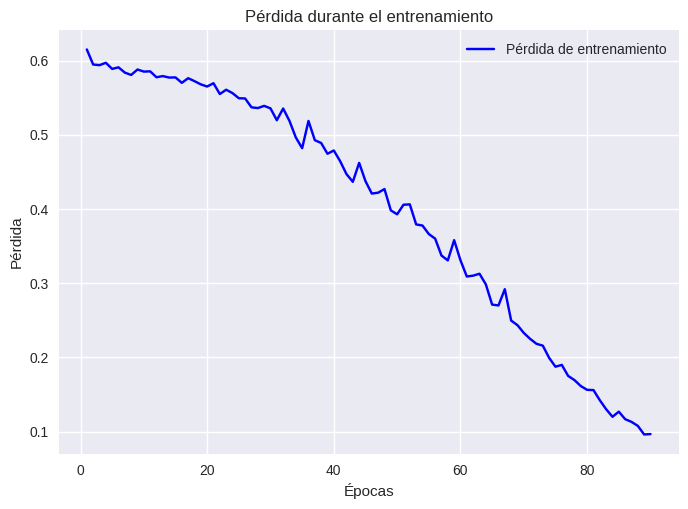

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
figure(figsize=(8, 5.5))
plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
title('Pérdida durante el entrenamiento')
xlabel('Épocas')
ylabel('Pérdida')
legend()
show()

In [ ]:
print(len(df_lstm.index))
print(len(predictions))

1824
31


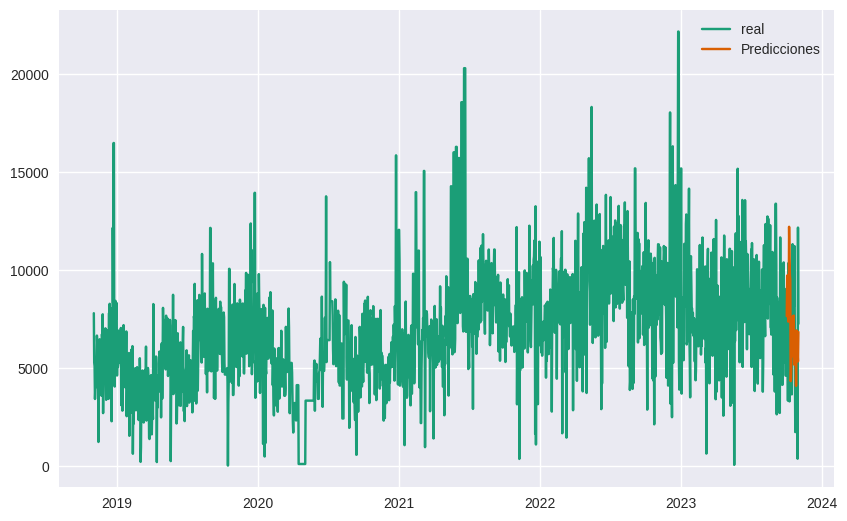

In [ ]:
longitud_predicciones = len(predictions)
# Visualizar las predicciones
figure(figsize=(10, 6.2))
plot(df_lstm['MontoBase'], label='real')
plot(df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones')
legend()
show()

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1764, 30, 1)
Forma de y: (1764,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 66ms/step


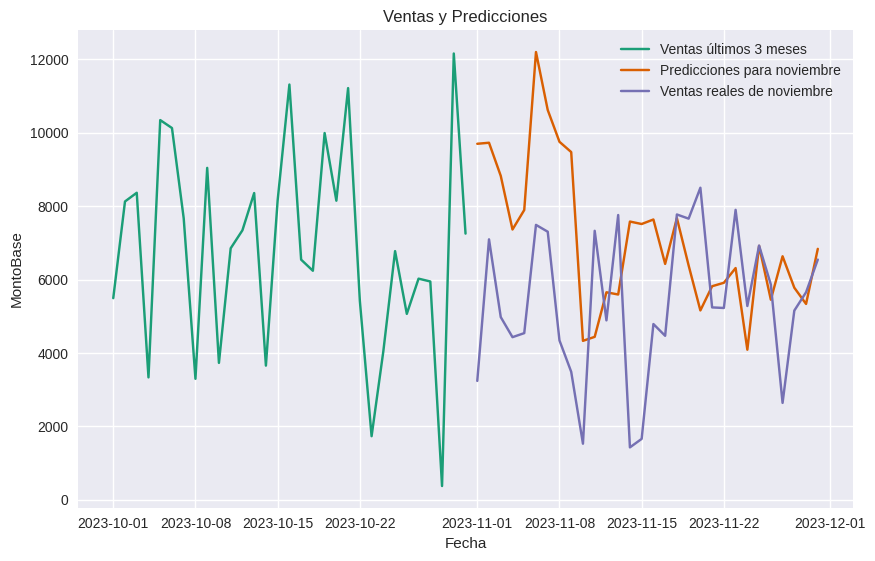

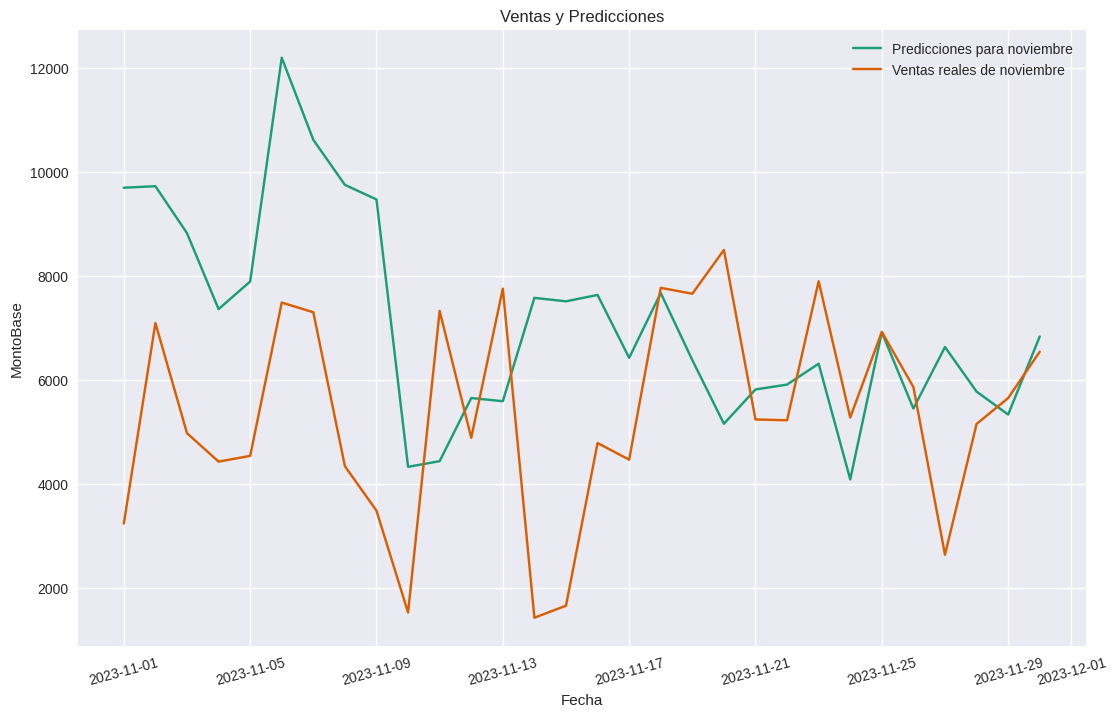

In [ ]:
# convertir a datetime el indice, que era la columna FechaMovimiento
df_lstm.index = to_datetime(df_lstm.index)

# Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-10-01']  # Este rango de meses es para graficar pocos datos
# start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
# last_3_months = df_lstm[df_lstm['FechaMovimiento'] >= start_date]
last_days = df_lstm.tail(90)
# last_days = df_lstm.tail(60)  # elegimos los ultimos valores para obtener la prediccion

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
# input_data = robust_scaler.transform(input_data.reshape(-1, 1))
# input_data, _ = create_sequences_1(input_data, seq_length)
# input_data, _ = create_sequences_1(input_data, seq_length)
input_data, _ = create_sequences_dwp(input_data, seq_length, 30)
# input_data, _ = create_sequences_d(input_data, seq_length)
# input_data, _ = create_temporal_sequences(input_data, seq_length)
# print("Forma de input_data:", input_data.shape)
# print("Contenido de input_data:", input_data)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Hacer predicciones para los siguientes 30 días
# predictions_future = model.predict(X_test)
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)
# predictions_future = robust_scaler.inverse_transform(predictions_future)

# Visualizar los resultados
figure(figsize=(10, 6.2))

# Datos de ventas de los últimos 3 meses
plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = date_range(start='2023-11-01', periods=len(predictions_future))
plot(dates_future, predictions_future, label='Predicciones para noviembre')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

figure(figsize=(13, 8))
dates_future = date_range(start='2023-11-01', periods=len(predictions_future))
plot(dates_future, predictions_future, label='Predicciones para noviembre')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
xticks(rotation=15)
show()

In [ ]:
# last_3_months.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Evaluar

In [ ]:
# creamos una nueva columna en el df de noviembre con las predicciones de LSTM
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future
print(df_noviembre_sumaT.tail(10))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_ARIMA  Ventas_LSTM
20      2023-11-21  5242.8209       6095.3891     2611.4835    5819.9966
21      2023-11-22  5227.2192       6458.4557     6689.2539    5914.0796
22      2023-11-23  7901.7048       7067.6190     1867.1481    6315.5864
23      2023-11-24  5280.7705       7149.6695     3246.4829    4089.8062
24      2023-11-25  6927.9113       8669.0715     4089.2376    6919.7583
25      2023-11-26  5866.7376       6918.5582     3184.6002    5453.3003
26      2023-11-27  2640.2740       7821.7908     2751.5863    6636.6489
27      2023-11-28  5156.1705       6007.1338     1516.7929    5779.6055
28      2023-11-29  5654.8998       6424.1376     6307.8236    5337.6841
29      2023-11-30  6546.1102       7094.8486     1738.0034    6839.0742


In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 10722863.93567838
MAE is : 2617.566551796874
R2 is : -1.771783914136638 %
------------------------------
RMSE is : 3274.5784363301455
MAPE is : 77.24046001041867 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## DESDE 2021

In [ ]:
df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021['FechaMovimiento'] = to_datetime(df_lstm_desde_2021['FechaMovimiento'])
# df_lstm_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_lstm_desde_2021)

# Normalizar los datos
df_lstm_desde_2021['MontoBase_scaler'] = scaler.fit_transform(df_lstm_desde_2021['MontoBase'].values.reshape(-1, 1))

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences_dwp(df_lstm_desde_2021['MontoBase_scaler'].values, seq_length, 30)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) - 31)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# # Construir el modelo LSTM
# model_2 = Sequential()
# model_2.add(LSTM(units=500, input_shape=(X_train.shape[1], X_train.shape[2])))

# Construir el modelo LSTM
model_2 = Sequential()
# 1º capa LSTM y Dropout para regularización.
model_2.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model_2.add(Dropout(rate=0.2))

# # 2º capa LSTM y Dropout para regularización.
# model_2.add(LSTM(units = 100, return_sequences = True))
# model_2.add(Dropout(rate=0.1))

# 3ºa capa LSTM y Dropout para regularización.
model_2.add(LSTM(units = 200, return_sequences = False))
model_2.add(Dropout(rate=0.2))

# Capa de Salida!
model_2.add(Dense(units = 100, activation='relu'))
model_2.add(Dense(units = 1))
# Resumen del modelo!
model_2.summary()
model_2.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=110, batch_size=30, verbose=1)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler.inverse_transform(predictions_2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     FechaMovimiento  MontoBase
790       2021-01-01 12048.0190
791       2021-01-02 10510.9000
792       2021-01-03  4100.4080
793       2021-01-04  4341.8650
794       2021-01-05  4555.7320
...              ...        ...
1819      2023-10-27  6026.4036
1820      2023-10-28  5949.4542
1821      2023-10-29   374.6544
1822      2023-10-30 12163.1227
1823      2023-10-31  7254.2832

[1034 rows x 2 columns]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 200)           161600    
                                                                 
 dropout_12 (Dropout)        (None, 30, 200)           0         
                                                                 
 lstm_13 (LSTM)              (None, 200)               320800    
                                                                 
 dropout_13 (Dropout)        (None, 200) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


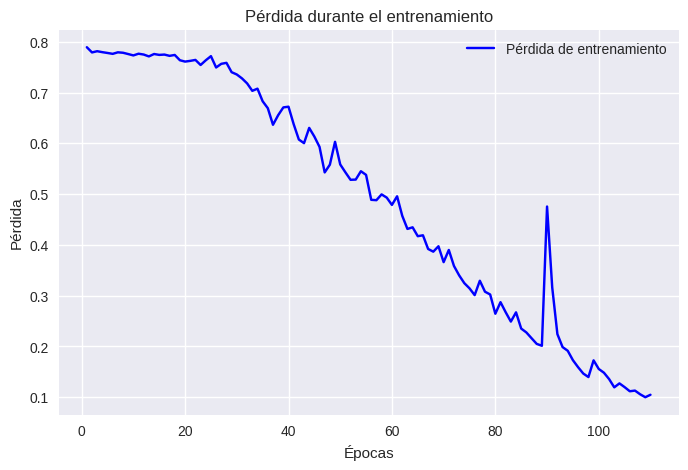

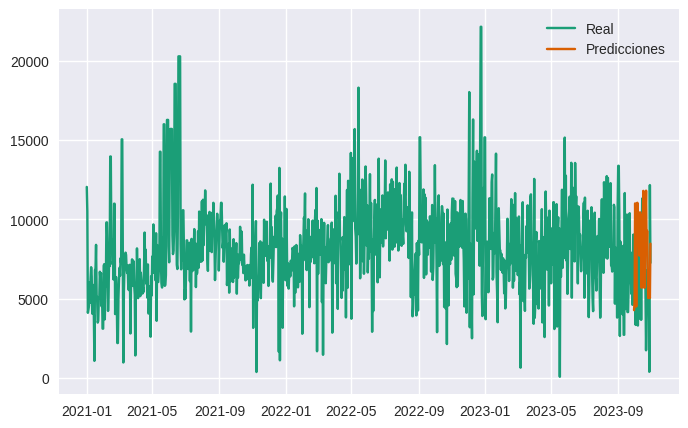

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
figure(figsize=(8, 5))
plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
title('Pérdida durante el entrenamiento')
xlabel('Épocas')
ylabel('Pérdida')
legend()
show()

# # Visualizar las predicciones
# plot(df_lstm_desde_2021['MontoBase'], label='real')
# plot(df_lstm_desde_2021['FechaMovimiento'], predictions_2.flatten(), label='Predicciones')
# legend()
# show()

# Crear un rango de fechas para las predicciones
fechas_predicciones = date_range(start='2023-10-01', periods=len(predictions_2))

# Visualizar las predicciones
figure(figsize=(8, 5))
plot(df_lstm_desde_2021['FechaMovimiento'], df_lstm_desde_2021['MontoBase'], label='Real')
plot(fechas_predicciones, predictions_2.flatten(), label='Predicciones')
legend()
show()


Forma de X: (974, 30, 1)
Forma de y: (974,)
1/1 [==============================] - 0s 77ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


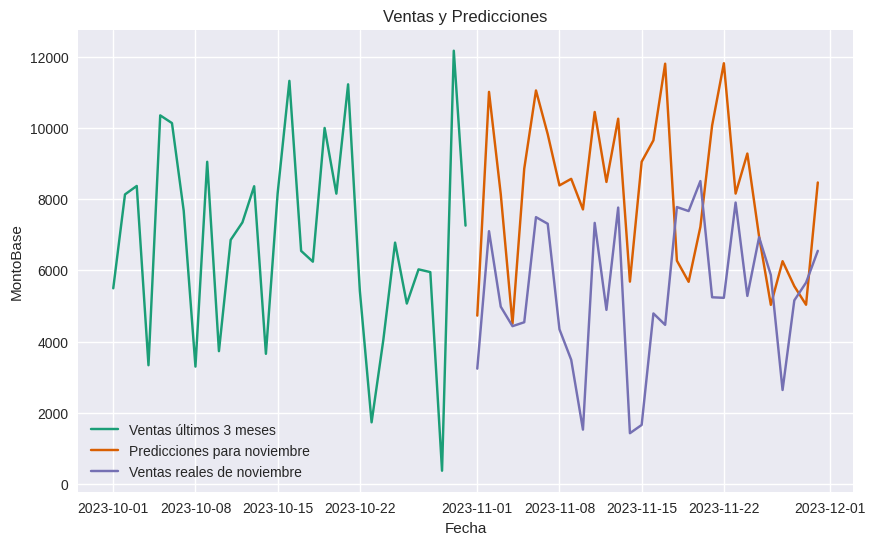

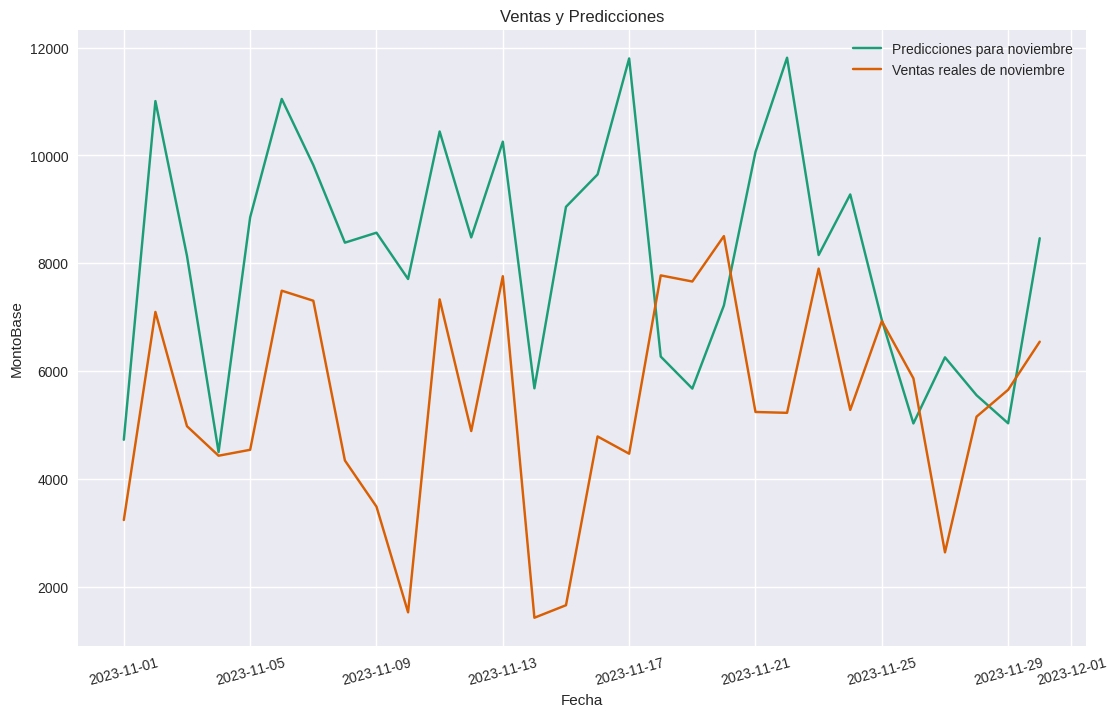

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# df_lstm_desde_2021.index = to_datetime(df_lstm_desde_2021.index)
df_lstm_desde_2021['FechaMovimiento'] = to_datetime(df_lstm_desde_2021['FechaMovimiento'])

# Preparar datos de entrada para las predicciones
# last_3_months = df_lstm_desde_2021[df_lstm_desde_2021.index >= '2023-10-01']   # Este rango de meses es para graficar pocos datos
last_3_months = df_lstm_desde_2021[df_lstm_desde_2021['FechaMovimiento'] >= '2023-10-01']
last_days = df_lstm.tail(90)  # elegimos los ultimos valores para obtener la prediccion

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
# input_data, _ = create_sequences(input_data, seq_length)
input_data, _ = create_sequences_dwp(input_data, seq_length, 30)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Visualizar los resultados
figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plot(last_3_months['FechaMovimiento'], last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = date_range(start='2023-11-01', periods=len(predictions_2_future))
plot(dates_future, predictions_2_future, label='Predicciones para noviembre')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

figure(figsize=(13, 8))
dates_future = date_range(start='2023-11-01', periods=len(predictions_2_future))
plot(dates_future, predictions_2_future, label='Predicciones para noviembre')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
xticks(rotation=15)
show()

### Evaluar

In [ ]:
# creamos una nueva columna en el df de noviembre desde 2021 con las predicciones de LSTM
df_noviembre_desde_2021['Ventas_LSTM'] = predictions_2_future

print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_ARIMA  Ventas_LSTM
0       2023-11-01  3239.2974       5414.5022     6604.0551    4727.4531
1       2023-11-02  7098.1327       5993.6987     4494.9412   11007.9736
2       2023-11-03  4978.8291       6453.2464     4755.3811    8136.1177
3       2023-11-04  4431.8618       8244.6862     2073.9223    4499.6777
4       2023-11-05  4541.8035       5783.0956     7118.1588    8852.7598
5       2023-11-06  7492.0734       6858.3319     3945.0324   11047.6943
6       2023-11-07  7305.7163       4838.8851     1980.7724    9820.3047
7       2023-11-08  4343.5560       5496.7389     4144.0696    8382.6035
8       2023-11-09  3487.1891       6089.6424     3288.4868    8567.3984
9       2023-11-10  1528.0410       6560.0966     6384.4729    7708.8413
10      2023-11-11  7330.7520       8359.6463     2514.0276   10443.8633
11      2023-11-12  4889.5888       5903.4763     4200.5422    8479.7969
12      2023-11-13  7760.8445       6981.6532     5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 14421413.483257078
MAE is : 3172.421731197916
R2 is : -2.727832615594623 %
------------------------------
RMSE is : 3797.5536182201663
MAPE is : 89.9722377913347 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00


In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-03,7795.8660
1,2018-11-04,5278.5900
2,2018-11-05,5096.8520
3,2018-11-06,3420.9820
4,2018-11-07,3968.6880


## CON TODOS LOS AÑOS



In [ ]:
# df_arima = df_todo_hasta_nov_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })
df_arima = df_todas_fechas_hasta_nov[['FechaMovimiento', 'MontoBase']]

# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-03       7795.8660
2018-11-04       5278.5900
2018-11-05       5096.8520
2018-11-06       3420.9820
2018-11-07       3968.6880
...                    ...
2023-10-27       6026.4036
2023-10-28       5949.4542
2023-10-29        374.6544
2023-10-30      12163.1227
2023-10-31       7254.2832

[1824 rows x 1 columns]>


In [ ]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-11-03 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1824 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


### Identificar si los datos son estacionarios o no


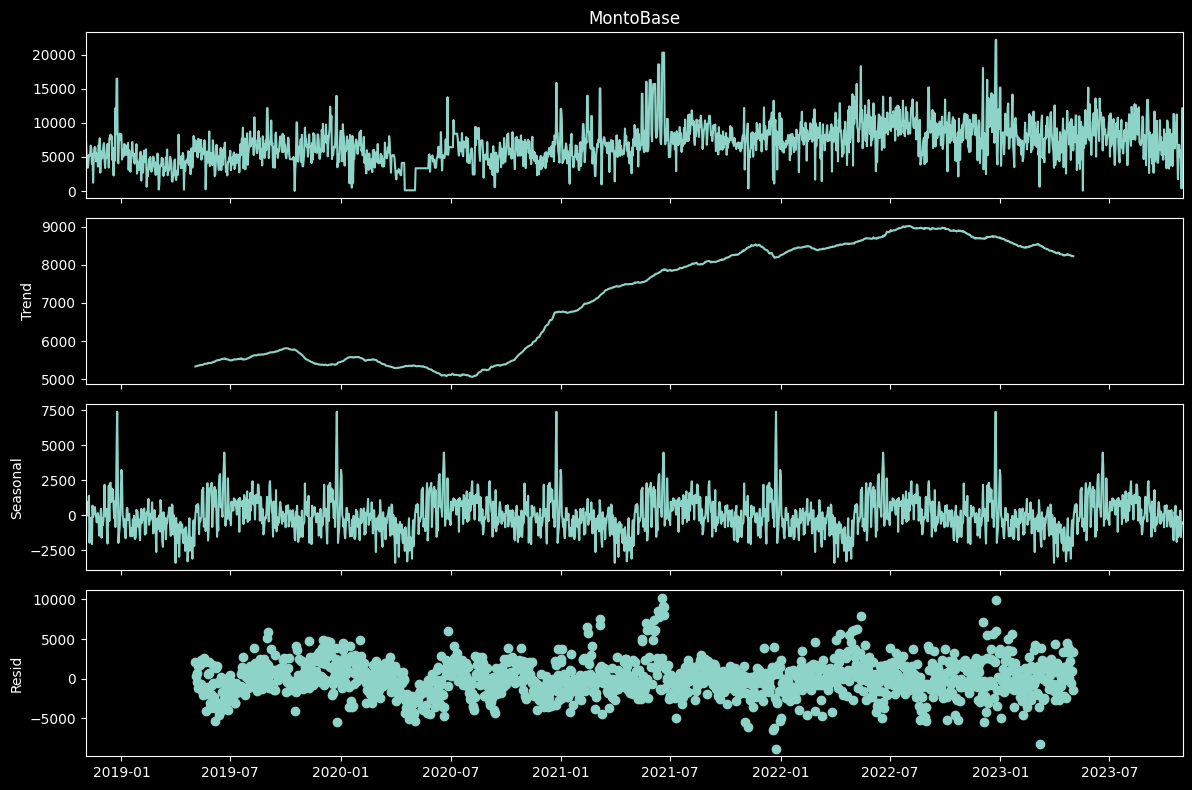

In [ ]:
#style.use('seaborn')
style.use('dark_background')
rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-03,7795.8660
2018-11-04,5278.5900
2018-11-05,5096.8520
2018-11-06,3420.9820
2018-11-07,3968.6880
...,...
2023-10-27,6026.4036
2023-10-28,5949.4542
2023-10-29,374.6544


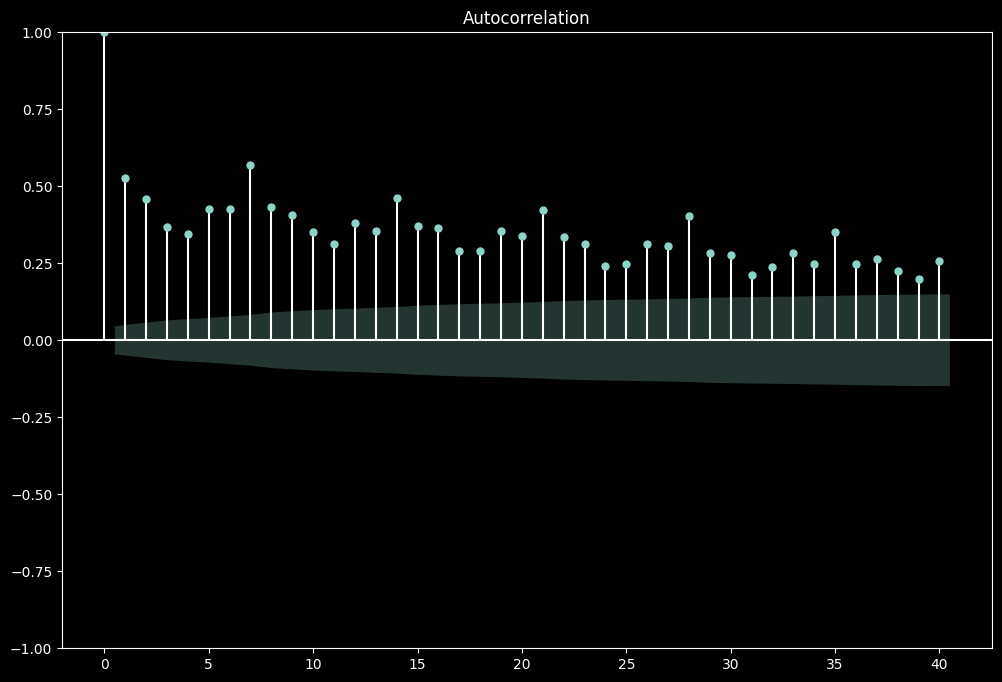

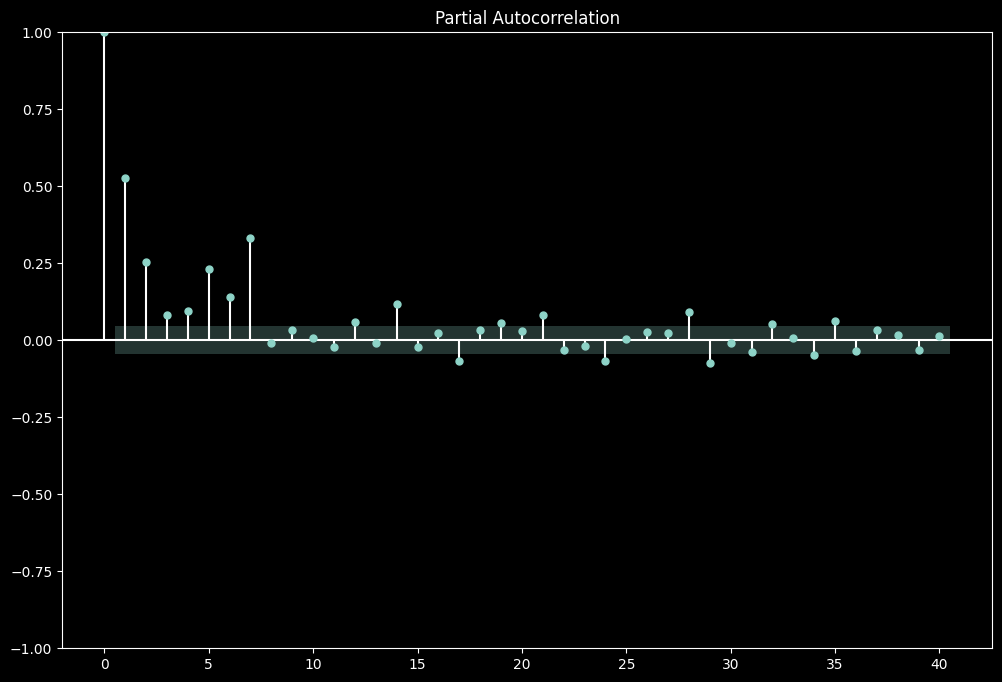

In [ ]:
# Resetear el indice y dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime
df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
show()

plot_pacf(df_arima['MontoBase'], lags=40)
show()

### prueba de Dickey-Fuller

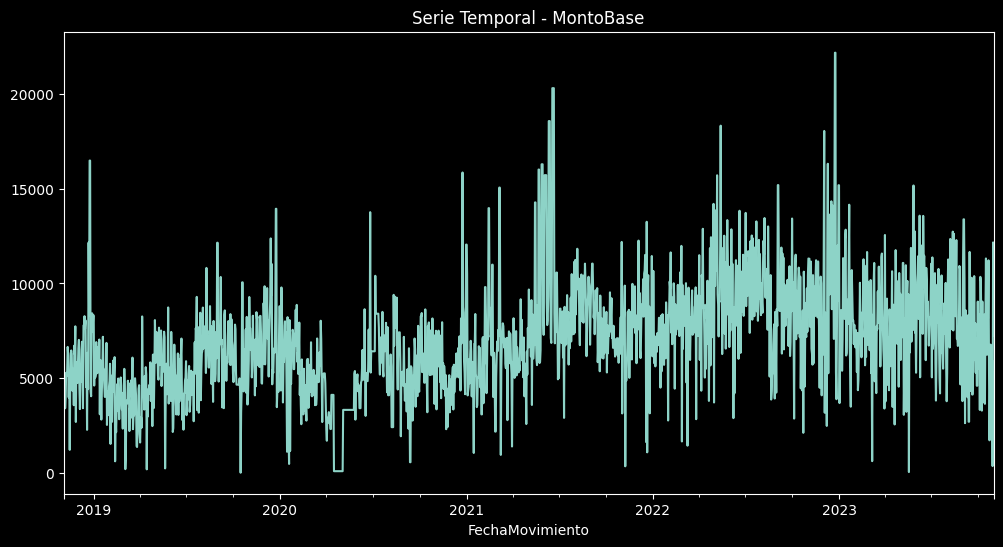

count    1824.0000
mean     6997.5028
std      2985.2699
min        24.9200
25%      5040.7153
50%      6819.8030
75%      8577.5530
max     22160.3236
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -3.9751366355174973
P-valor: 0.001546447468664259
Valores críticos: {'1%': -3.4339881389288407, '5%': -2.863147035877915, '10%': -2.567625533641975}


In [ ]:
# Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
title('Serie Temporal - MontoBase')
show()

# Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')
# si el resultado de p-valor es menor a 0.05 se acepta que los datos son estacionales

In [ ]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [ ]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -3.9751
p-value                                 0.0015
No Lags Used                           23.0000
Número de observaciones utilizadas   1800.0000
Critical Value (1%)                    -3.4340
Critical Value (5%)                    -2.8631
Critical Value (10%)                   -2.5676
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### Dividir en train y test

In [ ]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]

# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

In [ ]:
train.shape, test.shape

((1793, 1), (31, 1))

### más pruebas


In [ ]:
# display(df_arima.head(10))
# #df_arima = df_arima.set_index('FechaMovimiento')
# df_arima = df_arima.asfreq('D')
# display(df_arima.head(10))
# #df_arima = df_arima.asfreq(None)

In [ ]:
print(df_arima.isnull().sum())

MontoBase    0
dtype: int64


In [ ]:
df_arima = df_arima.dropna()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -3.9751366355174973, p-value: 0.001546447468664259
KPSS Statistic: 3.637878159575207, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -11.08863428981601, p-value: 4.135559550344874e-20
KPSS Statistic: 0.18546114161925, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -17.05344912448014, p-value: 8.039734514713223e-30
KPSS Statistic: 0.010065699939876029, p-value: 0.1


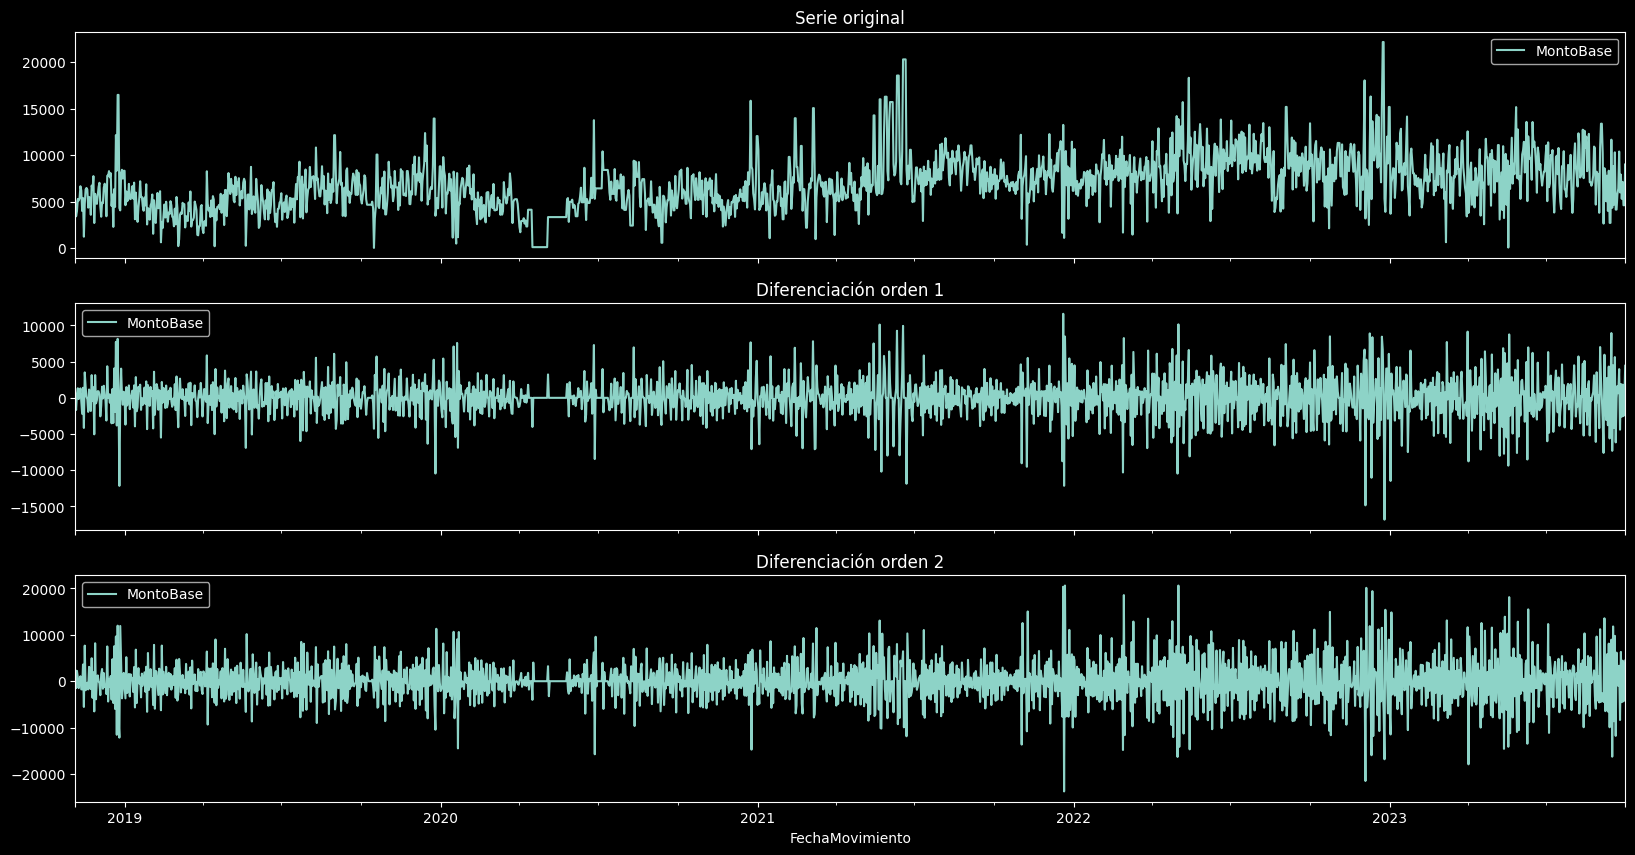

In [ ]:
from statsmodels.tsa.stattools import kpss
from warnings import filterwarnings
# Test estacionariedad
# ==============================================================================
filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


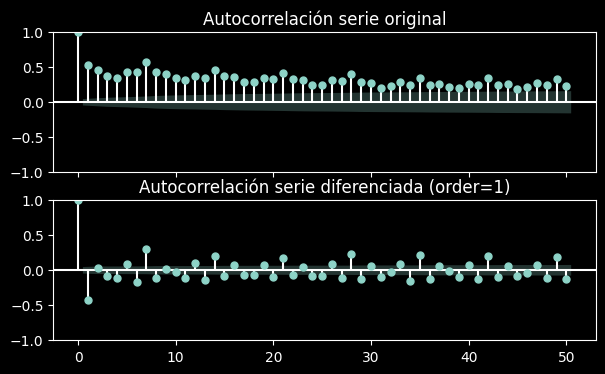

In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

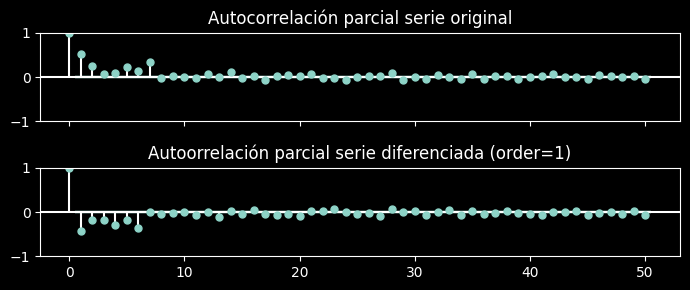

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
tight_layout();

In [ ]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [ ]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
filterwarnings("default")

ADF Statistic: -13.159885167904799, p-value: 1.3139592750979204e-24
KPSS Statistic: 0.054932048956156845, p-value: 0.1


### auto_arima


In [ ]:
# # Modelo Auto-Arima
# from pmdarima import auto_arima

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
#           max_p=4,max_d=2,max_q=4, start_P=0,
#           D=1, start_Q=0, max_P=2,max_D=1,
#           max_Q=1, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=34459.987, Time=0.56 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=33896.604, Time=14.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=15.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=34251.591, Time=0.71 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=33733.077, Time=9.02 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=25.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=33998.065, Time=2.97 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=33664.147, Time=7.80 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=33873.113, Time=2.68 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=37.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=13.23 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=33614.098, Time=6.97 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=33815.738, Time=3.14 sec
 ARIMA(3,1,0)(2,1,1)[12]      

In [ ]:
# print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1793
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 12)   Log Likelihood              -16580.442
Date:                             Tue, 19 Mar 2024   AIC                          33176.885
Time:                                     03:44:29   BIC                          33220.760
Sample:                                 11-03-2018   HQIC                         33193.090
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0001      0.028     -0.004      0.997      -0.055       0.055
ar.L2         -0.0309      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### implementación del modelo

In [ ]:
print(train)
print(train_size)
print(len(df_arima))
print(len(train))
print(len(test))

                 MontoBase
FechaMovimiento           
2018-11-03       7795.8660
2018-11-04       5278.5900
2018-11-05       5096.8520
2018-11-06       3420.9820
2018-11-07       3968.6880
...                    ...
2023-09-26       5299.5940
2023-09-27       7122.2784
2023-09-28       4609.1587
2023-09-29       4609.1587
2023-09-30       9043.4235

[1793 rows x 1 columns]
1793
1824
1793
31


In [ ]:
# style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
arima_model = SARIMAX(train["MontoBase"], order = (3,1,0), seasonal_order = (1,1,0,12))
arima_result = arima_model.fit()
filterwarnings("default")
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is depre

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MontoBase   No. Observations:                 1793
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -16902.869
Date:                            Tue, 19 Mar 2024   AIC                          33815.738
Time:                                    04:09:28   BIC                          33843.160
Sample:                                11-03-2018   HQIC                         33825.866
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4579      0.020    -23.453      0.000      -0.496      -0.420
ar.L2         -0.2522      0.025    -10.034      0.000      -0.301      -0.203
ar.L3         -0.1824      0.024     -7.714      0.000      -0.229      -0.136
ar.S.L12      -0.4180      0.021    -20.193      0.000      -0.459      -0.377
sigma2      1.233e+07   3.79e+05     32.566      0.000    1.16e+07    1.31e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.60   Jarque-Bera (JB):               217.33
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [ ]:
arima_pred = arima_result.predict(start = len(train), end = len(train+test)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-10-01   5147.3683
2023-10-02   3233.0007
2023-10-03   5897.6672
2023-10-04   4609.8280
2023-10-05   8732.6181
2023-10-06   3740.6792
2023-10-07   4906.0784
2023-10-08   7128.0043
2023-10-09   5131.9767
2023-10-10   5531.3543
2023-10-11   3802.4411
2023-10-12   8736.2375
2023-10-13   3896.7995
2023-10-14   2781.5389
2023-10-15   5017.9896
2023-10-16   4534.7736
2023-10-17   8591.7127
2023-10-18   3848.1903
2023-10-19   5326.5150
2023-10-20   5531.1151
2023-10-21   5131.4734
2023-10-22   4313.3048
2023-10-23   3307.1449
2023-10-24   8032.1167
2023-10-25   3587.0510
2023-10-26   2137.7321
2023-10-27   4553.1935
2023-10-28   3733.6141
2023-10-29   7818.0817
2023-10-30   2970.7116
2023-10-31   4318.2215
Freq: D, Name: ARIMA_Predictions, dtype: float64

In [ ]:
arima_pred.index = test.index

# Ahora se ven las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01   5147.3683
2023-10-02   3233.0007
2023-10-03   5897.6672
2023-10-04   4609.8280
2023-10-05   8732.6181
2023-10-06   3740.6792
2023-10-07   4906.0784
2023-10-08   7128.0043
2023-10-09   5131.9767
2023-10-10   5531.3543
2023-10-11   3802.4411
2023-10-12   8736.2375
2023-10-13   3896.7995
2023-10-14   2781.5389
2023-10-15   5017.9896
2023-10-16   4534.7736
2023-10-17   8591.7127
2023-10-18   3848.1903
2023-10-19   5326.5150
2023-10-20   5531.1151
2023-10-21   5131.4734
2023-10-22   4313.3048
2023-10-23   3307.1449
2023-10-24   8032.1167
2023-10-25   3587.0510
2023-10-26   2137.7321
2023-10-27   4553.1935
2023-10-28   3733.6141
2023-10-29   7818.0817
2023-10-30   2970.7116
2023-10-31   4318.2215
Name: ARIMA_Predictions, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


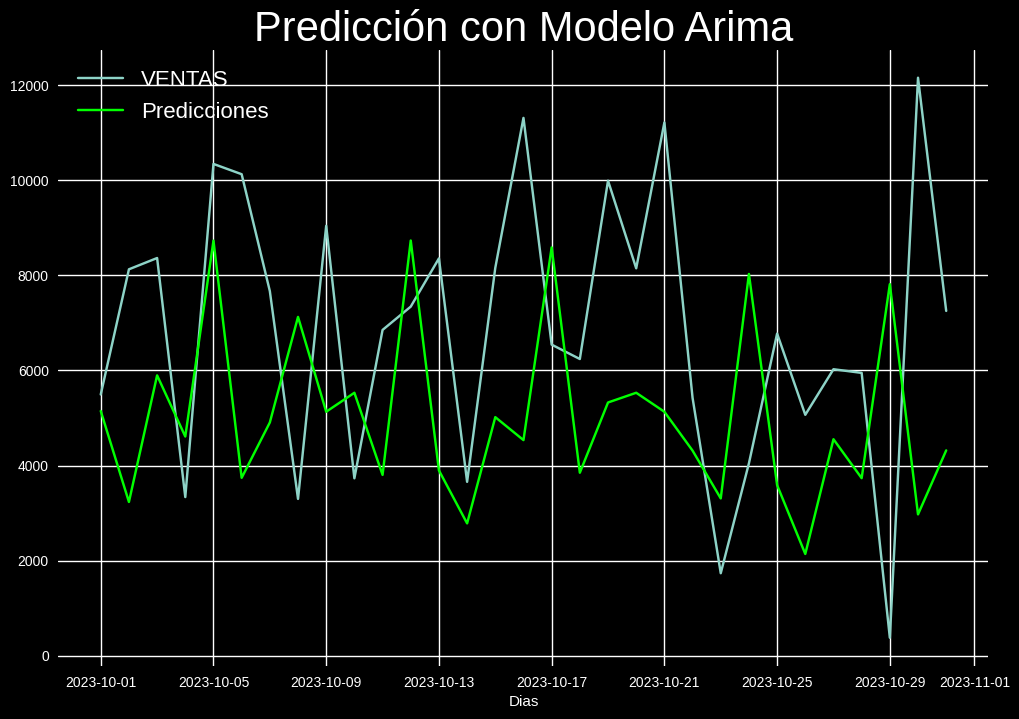

In [ ]:
style.use('dark_background')
rcParams["figure.figsize"] = (12, 8)

plot(test["MontoBase"], label="VENTAS")
plot(arima_pred, color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30);
xlabel('Dias')
ylabel('')
legend( fontsize=16);
show();

In [ ]:
print(train_size)
arima_pred2 = arima_result.predict(start = len(df_arima),end=len(df_arima)+29, typ="levels").rename("ARIMA Predictions")
arima_pred2

# start = 1699,end=1728

1793


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-11-01   5366.1407
2023-11-02   4299.1489
2023-11-03   3989.9611
2023-11-04   2681.6627
2023-11-05   7493.9311
2023-11-06   2884.0027
2023-11-07   1574.3330
2023-11-08   3914.9610
2023-11-09   3235.9944
2023-11-10   7308.9540
2023-11-11   2504.9962
2023-11-12   3907.1917
2023-11-13   4602.5714
2023-11-14   3814.5574
2023-11-15   3292.5961
2023-11-16   2110.6031
2023-11-17   6886.3783
2023-11-18   2345.3688
2023-11-19    977.3204
2023-11-20   3349.2316
2023-11-21   2611.4835
2023-11-22   6689.2539
2023-11-23   1867.1481
2023-11-24   3246.4829
2023-11-25   4089.2376
2023-11-26   3184.6002
2023-11-27   2751.5863
2023-11-28   1516.7929
2023-11-29   6307.8236
2023-11-30   1738.0034
Freq: D, Name: ARIMA Predictions, dtype: float64

In [ ]:
# print(df_noviembre_sumaT.head())
# #df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
# print(df_noviembre_sumaT.head())

In [ ]:
# Convertir el índice de las predicciones de ARIMA a un rango de fechas
fechas_prediccion = date_range(start=df_noviembre_sumaT['FechaMovimiento'].iloc[0], periods=len(arima_pred2))

# Crear un DataFrame con las fechas y las predicciones de ARIMA
df_predicciones_arima = DataFrame({'FechaMovimiento': fechas_prediccion, 'Ventas_ARIMA': arima_pred2.values})

<ipython-input-190-7e107327fd2a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


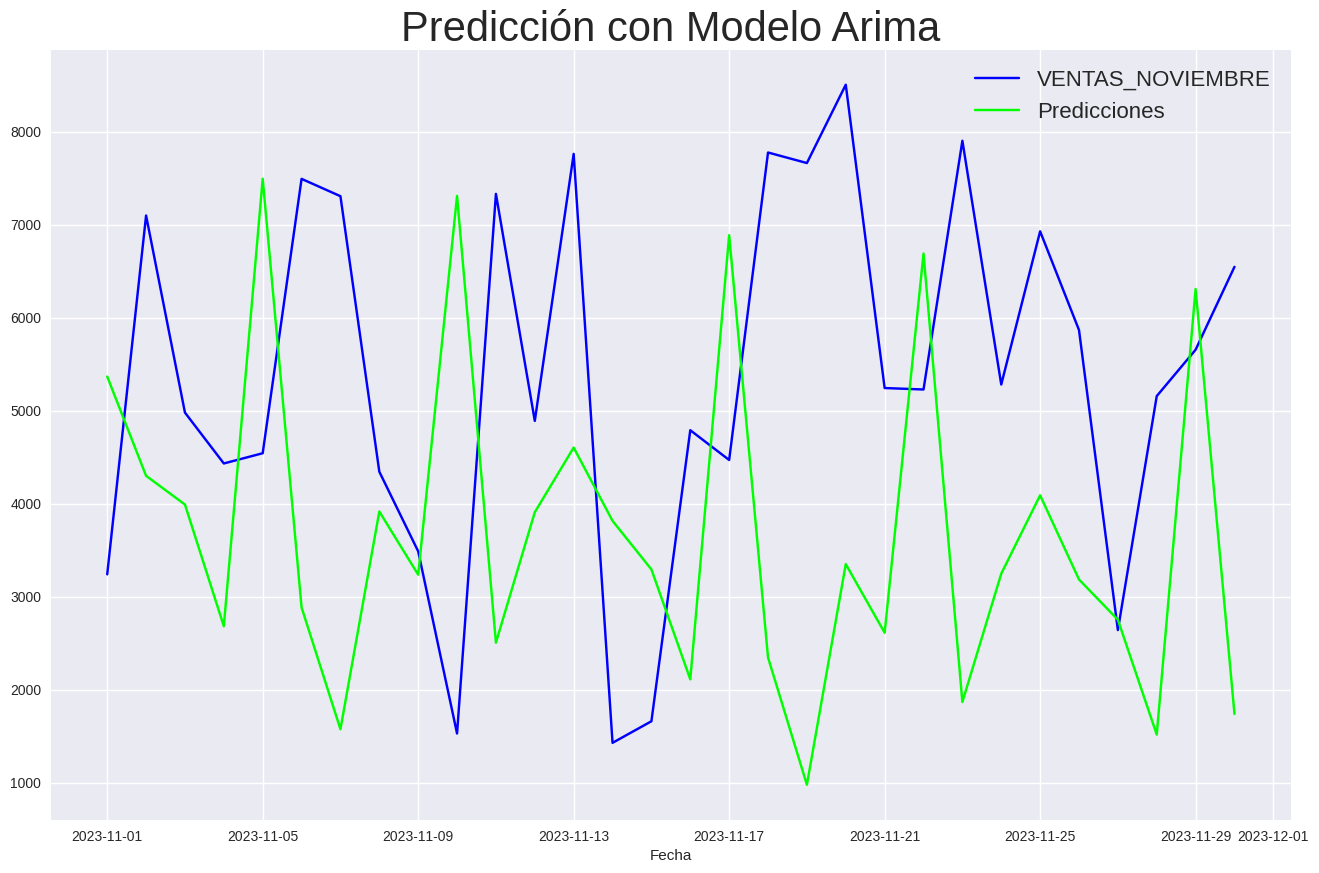

In [ ]:
style.use('seaborn')
rcParams["figure.figsize"] = (16, 10)

#plot(test["MontoBase"],color="blue" ,label="VENTAS")
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT["MontoBase"], color="BLUE" ,label="VENTAS_NOVIEMBRE")
plot(df_predicciones_arima['FechaMovimiento'],df_predicciones_arima['Ventas_ARIMA'], color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30);
xlabel('Fecha')
ylabel('')
legend( fontsize=16);
show();

## Evaluar


In [ ]:
# creamos una nueva columna en el df de noviembre con las predicciones de ARIMA
# df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2
df_noviembre_sumaT['Ventas_ARIMA'] = df_predicciones_arima['Ventas_ARIMA']

print(df_noviembre_sumaT.head(10))

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_ARIMA
0      2023-11-01  3239.2974       6466.6419     5366.1407
1      2023-11-02  7098.1327       7141.8419     4299.1489
2      2023-11-03  4978.8291       7284.2322     3989.9611
3      2023-11-04  4431.8618       8855.8544     2681.6627
4      2023-11-05  4541.8035       7147.1436     7493.9311
5      2023-11-06  7492.0734       8079.6523     2884.0027
6      2023-11-07  7305.7163       6279.8858     1574.3330
7      2023-11-08  4343.5560       6695.8417     3914.9610
8      2023-11-09  3487.1891       7348.3691     3235.9944
9      2023-11-10  1528.0410       7462.3725     7308.9540


In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 12363078.228506638
MAE is : 2988.809210330214
R2 is : -2.195767620343272 %
------------------------------
RMSE is : 3516.116924749039
MAPE is : 64.1405742243356 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**RESULTADOS** ▶

Con datos rellenados con valores del dia anterior
order = (4,1,1), seasonal_order = (2,1,0,12)
- RMSE is : 3869.433823460291
- MAPE is : 66.67357320516145 %
+NO PORQUE TIENE VALORES NEGATIVOS

order = (4,1,0), seasonal_order = (2,1,0,12)
- VALORES NEGATIVOS

order = (3,1,0), seasonal_order = (2,1,0,12)
- RMSE is : 3645.994758854619
- MAPE is : 65.72600596408351 %

___
order = (3,1,0), seasonal_order = (1,1,0,12)
- RMSE is : 3516.116924749039
- MAPE is : 64.1405742243356 %
___

order = (3,1,1), seasonal_order = (1,1,0,12)
- VALORES NEGATIVOS
- RMSE is : 4128.7578209652
- MAPE is : 68.32123624118513 %

order = (3,1,0), seasonal_order = (1,1,1,12)
- LINEA CASI RECTA
- RMSE is : 2675.8781883287916
- MAPE is : 72.46707204424659 %

order = (3,1,0), seasonal_order = (0,1,0,12)
- RMSE is : 4961.57358365174
- MAPE is : 80.304582027791 %

-RECOMENDADO POR SARIMAX
order = (4,1,2), seasonal_order = (2,1,0,12)
- RMSE is : 3965.805443034823
- MAPE is : 67.20214213804734 %
- VALORES NEGATIVOS

order = (3,1,2), seasonal_order = (1,1,0,12)
- RMSE is : 3105.572962262409
- MAPE is : 75.82691347631335 %

___
order = (2,1,0), seasonal_order = (1,1,0,12)
+ RMSE is : 3249.1145283941055
+ MAPE is : 64.21849715938043 %
___





## Desde el 2021

In [ ]:
# df_arima_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

df_arima_desde_2021 = df_todas_fechas_hasta_nov_desde_2021[['FechaMovimiento', 'MontoBase']]

# Establecer la columna 'FechaMovimiento' como índice
df_arima_desde_2021.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

print(df_arima_desde_2021.dtypes)
print(df_arima_desde_2021.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2021-01-01      12048.0190
2021-01-02      10510.9000
2021-01-03       4100.4080
2021-01-04       4341.8650
2021-01-05       4555.7320
...                    ...
2023-10-27       6026.4036
2023-10-28       5949.4542
2023-10-29        374.6544
2023-10-30      12163.1227
2023-10-31       7254.2832

[1034 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


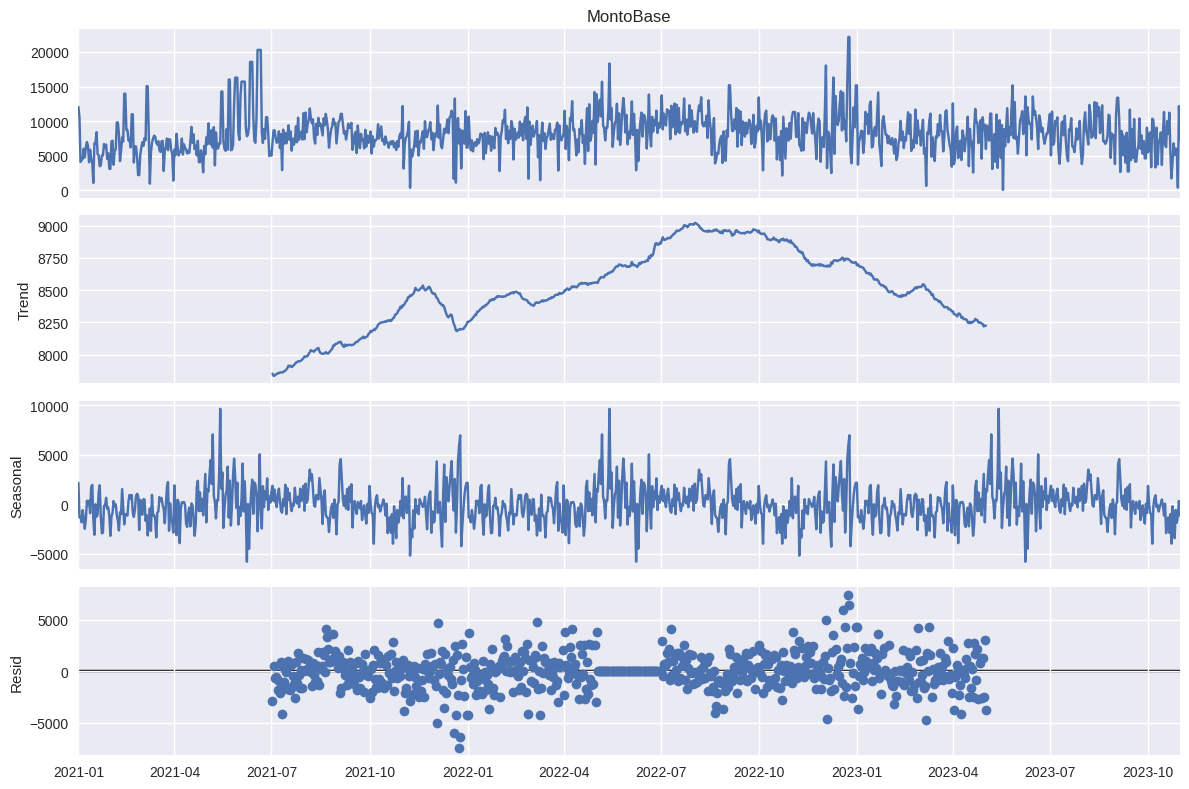

In [ ]:
rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_desde_2021["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_d21 = int(len(df_arima_desde_2021) - 31)
train_d21, test_d21 = df_arima_desde_2021[0:train_size_d21], df_arima_desde_2021[train_size_d21:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_d21.shape, test_d21.shape

((1003, 1), (31, 1))

In [ ]:
print(train_d21)

                 MontoBase
FechaMovimiento           
2021-01-01      12048.0190
2021-01-02      10510.9000
2021-01-03       4100.4080
2021-01-04       4341.8650
2021-01-05       4555.7320
...                    ...
2023-09-26       5299.5940
2023-09-27       7122.2784
2023-09-28       4609.1587
2023-09-29       4609.1587
2023-09-30       9043.4235

[1003 rows x 1 columns]


In [ ]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train_d21['MontoBase'],start_p=0,d=0,start_q=0,
#           max_p=4,max_d=2,max_q=4, start_P=0,
#           D=0, start_Q=0, max_P=2,max_D=1,
#           max_Q=2, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print(modelo_auto.summary())

In [ ]:
arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (3,1,0), seasonal_order = (3,1,0,12))
arima_result_d21 = arima_model_d21.fit()
arima_result_d21.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is depre

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MontoBase   No. Observations:                 1003
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -9421.199
Date:                            Tue, 19 Mar 2024   AIC                          18856.399
Time:                                    04:42:13   BIC                          18890.683
Sample:                                01-01-2021   HQIC                         18869.435
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6127      0.023    -26.083      0.000      -0.659      -0.567
ar.L2         -0.2858      0.031     -9.087      0.000      -0.347      -0.224
ar.L3         -0.1592      0.029     -5.553      0.000      -0.215      -0.103
ar.S.L12      -0.6922      0.028    -24.731      0.000      -0.747      -0.637
ar.S.L24      -0.5682      0.034    -16.739      0.000      -0.635      -0.502
ar.S.L36      -0.2660      0.031     -8.597      0.000      -0.327      -0.205
sigma2      1.075e+07   4.26e+05     25.213      0.000    9.91e+06    1.16e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.84   Jarque-Bera (JB):                43.19
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_pred_d21 = arima_result_d21.predict(start = len(df_arima_desde_2021), end = len(df_arima_desde_2021)+29, typ="levels")
print(arima_pred_d21)
# o start = 965 , end = 994
# start = len(train_d21), end = len(df_arima_desde_2021)-2

2023-11-01   6604.0551
2023-11-02   4494.9412
2023-11-03   4755.3811
2023-11-04   2073.9223
2023-11-05   7118.1588
2023-11-06   3945.0324
2023-11-07   1980.7724
2023-11-08   4144.0696
2023-11-09   3288.4868
2023-11-10   6384.4729
2023-11-11   2514.0276
2023-11-12   4200.5422
2023-11-13   5116.7600
2023-11-14   4550.0585
2023-11-15   3620.6059
2023-11-16   1501.9243
2023-11-17   6306.5043
2023-11-18   4081.7981
2023-11-19   1414.1601
2023-11-20   3773.3464
2023-11-21   2512.1756
2023-11-22   5258.2010
2023-11-23   1534.6804
2023-11-24   3352.2613
2023-11-25   5299.3943
2023-11-26   4098.2770
2023-11-27   3520.4411
2023-11-28    609.8578
2023-11-29   5557.6047
2023-11-30   3275.1592
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Convertir el índice de las predicciones de ARIMA a un rango de fechas
fechas_prediccion = date_range(start=df_noviembre_desde_2021['FechaMovimiento'].iloc[0], periods=len(arima_pred_d21))

# Crear un DataFrame con las fechas y las predicciones de ARIMA
df_predicciones_arima_21 = DataFrame({'FechaMovimiento': fechas_prediccion, 'Ventas_ARIMA': arima_pred_d21.values})

# print(arima_pred_d21)
print(df_predicciones_arima_21)

   FechaMovimiento  Ventas_ARIMA
0       2023-11-01     6604.0551
1       2023-11-02     4494.9412
2       2023-11-03     4755.3811
3       2023-11-04     2073.9223
4       2023-11-05     7118.1588
5       2023-11-06     3945.0324
6       2023-11-07     1980.7724
7       2023-11-08     4144.0696
8       2023-11-09     3288.4868
9       2023-11-10     6384.4729
10      2023-11-11     2514.0276
11      2023-11-12     4200.5422
12      2023-11-13     5116.7600
13      2023-11-14     4550.0585
14      2023-11-15     3620.6059
15      2023-11-16     1501.9243
16      2023-11-17     6306.5043
17      2023-11-18     4081.7981
18      2023-11-19     1414.1601
19      2023-11-20     3773.3464
20      2023-11-21     2512.1756
21      2023-11-22     5258.2010
22      2023-11-23     1534.6804
23      2023-11-24     3352.2613
24      2023-11-25     5299.3943
25      2023-11-26     4098.2770
26      2023-11-27     3520.4411
27      2023-11-28      609.8578
28      2023-11-29     5557.6047
29      20

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-228-f7b92b09b903>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_ARIMA
0      2023-11-01  3239.2974       5414.5022     6859.3130
1      2023-11-02  7098.1327       5993.6987     5810.6432
2      2023-11-03  4978.8291       6453.2464     5492.9330
3      2023-11-04  4431.8618       8244.6862     4191.1526
4      2023-11-05  4541.8035       5783.0956     9000.6937
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_ARIMA
0      2023-11-01  3239.2974       5414.5022     6859.3130
1      2023-11-02  7098.1327       5993.6987     5810.6432
2      2023-11-03  4978.8291       6453.2464     5492.9330
3      2023-11-04  4431.8618       8244.6862     4191.1526
4      2023-11-05  4541.8035       5783.0956     9000.6937


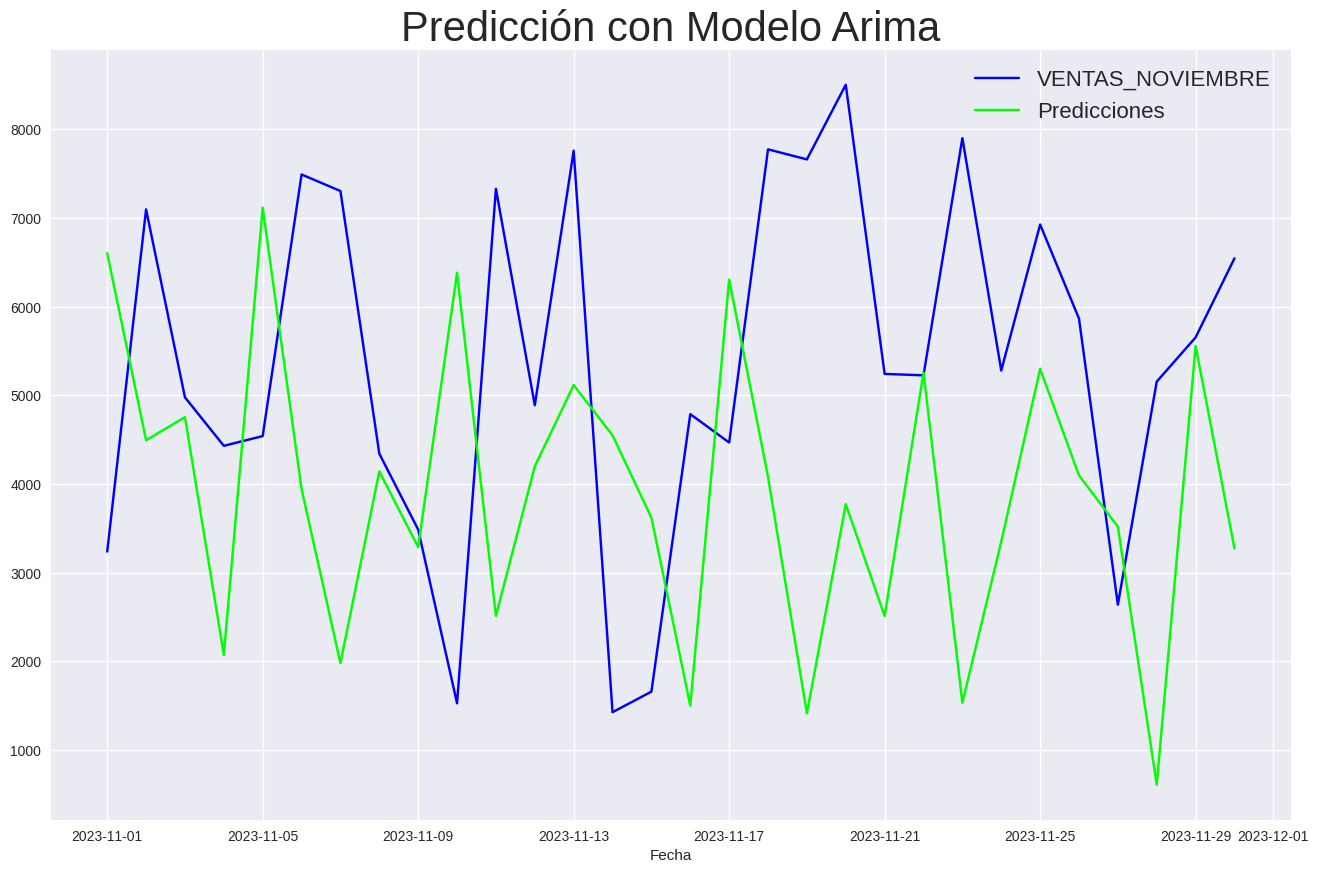

In [ ]:
print(df_noviembre_desde_2021.head())
#df_noviembre_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_desde_2021.head())

style.use('seaborn')
rcParams["figure.figsize"] = (16, 10)
#plot(test_d21["MontoBase"],color="blue" ,label="VENTAS")
plot(df_noviembre_desde_2021["FechaMovimiento"], df_noviembre_desde_2021["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plot(df_predicciones_arima_21['FechaMovimiento'],df_predicciones_arima_21['Ventas_ARIMA'], color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30);
xlabel('Fecha')
ylabel('')
legend( fontsize=16);
show();

## Evaluar

In [ ]:
# PARA ELIMINAR LA COLUMNA CON VALORES 'NaN'
# print(df_noviembre_desde_2021)
# df_noviembre_desde_2021.drop(columns=['Ventas_ARIMA'], inplace=True)
# print(df_noviembre_desde_2021)

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_ARIMA'] = df_predicciones_arima_21['Ventas_ARIMA']

# Imprimir el resultado
print(df_noviembre_desde_2021.head(30))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_ARIMA
0       2023-11-01  3239.2974       5414.5022     6604.0551
1       2023-11-02  7098.1327       5993.6987     4494.9412
2       2023-11-03  4978.8291       6453.2464     4755.3811
3       2023-11-04  4431.8618       8244.6862     2073.9223
4       2023-11-05  4541.8035       5783.0956     7118.1588
5       2023-11-06  7492.0734       6858.3319     3945.0324
6       2023-11-07  7305.7163       4838.8851     1980.7724
7       2023-11-08  4343.5560       5496.7389     4144.0696
8       2023-11-09  3487.1891       6089.6424     3288.4868
9       2023-11-10  1528.0410       6560.0966     6384.4729
10      2023-11-11  7330.7520       8359.6463     2514.0276
11      2023-11-12  4889.5888       5903.4763     4200.5422
12      2023-11-13  7760.8445       6981.6532     5116.7600
13      2023-11-14  1427.7825       4962.9729     4550.0585
14      2023-11-15  1659.6720       5619.8129     3620.6059
15      2023-11-16  4789.3392       6210

In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 10603421.406553173
MAE is : 2717.72909036349
R2 is : -1.7409088715287138 %
------------------------------
RMSE is : 3256.2895151618773
MAPE is : 61.50195620785986 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**RESULTADOS** ▶

Con datos rellenados con valores del dia anterior
order = (4,1,2), seasonal_order = (2,1,0,12)
- RMSE is : 3964.051516552064
- MAPE is : 67.17164183229464 %
+NO PORQUE TIENE VALORES NEGATIVOS

order = (4,1,1), seasonal_order = (2,1,0,12)
- VALORES NEGATIVOS
RMSE is : 3853.9794724824023
MAPE is : 66.66075305205919 %

order = (4,1,3), seasonal_order = (2,1,0,12)
- VALORES NEGATIVOS
RMSE is : 3849.3367693562427
MAPE is : 66.07403523876177 %

order = (6,1,0), seasonal_order = (2,1,0,12)
- VALORES NEGATIVOS
RMSE is : 3910.733507704278
MAPE is : 66.49190461951363 %

___
order = (2,1,0), seasonal_order = (2,1,0,12)
- RMSE is : 3739.98355273866
- MAPE is : 66.52249306108969 %
___

order = (2,1,0), seasonal_order = (2,0,0,12)
- LINEA CASI RECTA
RMSE is : 2625.4906580372704
MAPE is : 70.94793207935606 %

order = (2,1,0), seasonal_order = (2,1,1,12)
- RMSE is : 2843.4238634561034
- MAPE is : 76.38145872052758 %

order = (2,1,1), seasonal_order = (2,1,0,12)
- RMSE is : 3314.8964421490714
- MAPE is : 84.76010986639957 %


order = (2,1,0), seasonal_order = (3,1,0,12)
- RMSE is : 3285.9879795247984
- MAPE is : 61.85745178119749 %

___
order = (3,1,0), seasonal_order = (3,1,0,12)
- RMSE is : 3256.2895151618773
- MAPE is : 61.50195620785986 %
___

order = (3,1,0), seasonal_order = (2,1,0,12)
- RMSE is : 3667.309625213962
- MAPE is : 65.91248950901695 %

order = (3,1,0), seasonal_order = (1,1,0,12)
- RMSE is : 3490.3674917192857
- MAPE is : 64.00348942060933 %

RECOMENDACION DE SARIMAX
- ARIMA(2,0,0)(2,0,0)
- LINEA RECTA CON PENDIENTE NEGATIVA
RMSE is : 3601.3051124738904
MAPE is : 55.35165175394226 %

order = (2,1,0), seasonal_order = (1,1,0,12)
- RMSE is : 3230.0706607410802
- MAPE is : 64.21592404128437 %

order = (2,1,0), seasonal_order = (3,1,0,12)
- RMSE is : 3285.9879795247984
* MAPE is : 61.85745178119749 %


# TODAS LAS EVALUACIONES

In [ ]:
print("--"*10,"EVALUACIÓN CON TODOS LOS DATOS","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN DESDE EL 2021","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON TODOS LOS DATOS --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 7071201.030356657
MAE is : 2107.3865450620237
R2 is : -0.8278550755786516 %
------------------------------
RMSE is : 2659.172997448014
MAPE is : 70.24891224289186 %
------------------------------
---------- LSTM ----------
Evaluation metric results:-
MSE is : 10984976.496023117
MAE is : 2721.2721370052077
R2 is : -1.8395381431201234 %
------------------------------
RMSE is : 3314.3591380571775
MAPE is : 82.43078785742117 %
------------------------------
---------- ARIMA ----------
Evaluation metric results:-
MSE is : 12363078.228506638
MAE is : 2988.809210330214
R2 is : -2.195767620343272 %
------------------------------
RMSE is : 3516.116924749039
MAPE is : 64.1405742243356 %
------------------------------
-------------------- EVALUACIÓN DESDE EL 2021 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 4550463.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-289-013a27c72512>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


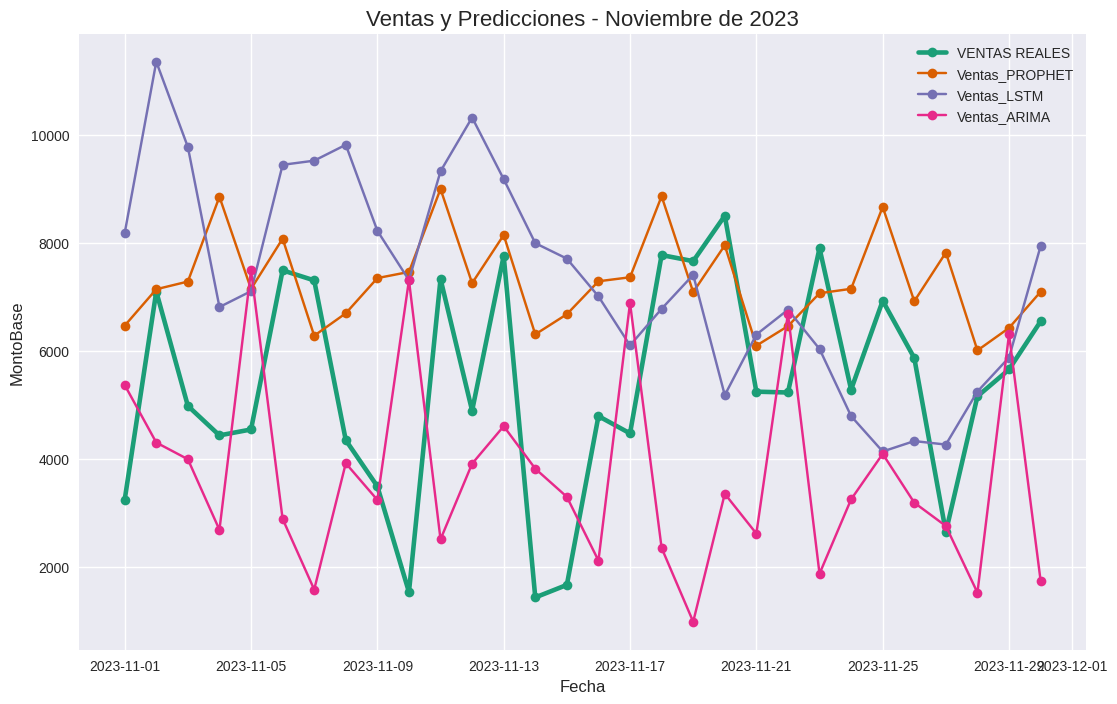

In [ ]:
style.use('seaborn')
set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
figure(figsize=(13, 8))
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
xlabel('Fecha', fontsize=12)
ylabel('MontoBase', fontsize=12)
legend()
show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-290-6be0af56d44e>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


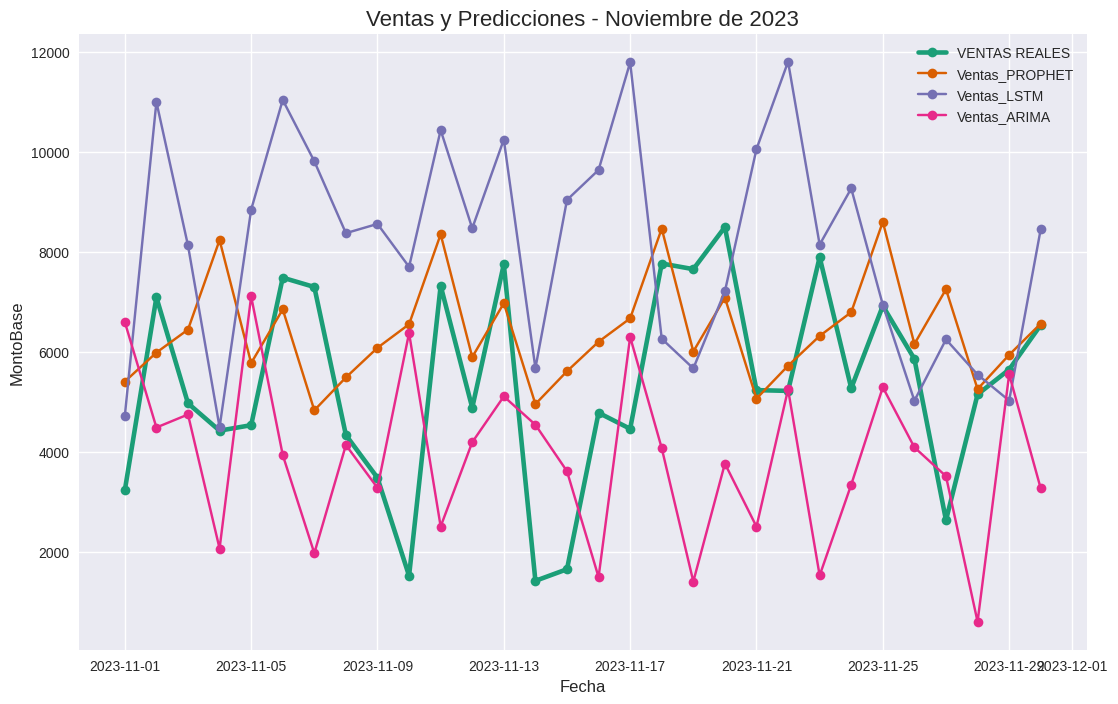

In [ ]:
style.use('seaborn')
set_palette("Dark2")

# Graficar los datos para df_noviembre_desde_2021
figure(figsize=(13, 8))
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
xlabel('Fecha', fontsize=12)
ylabel('MontoBase', fontsize=12)
legend()
show()